In [301]:
import pandas as pd
import numpy as np

path_to_train_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\train.csv"
path_to_test_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\test.csv"
train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)

# 1.Inspect the raw data

## 1.1 Check correlation

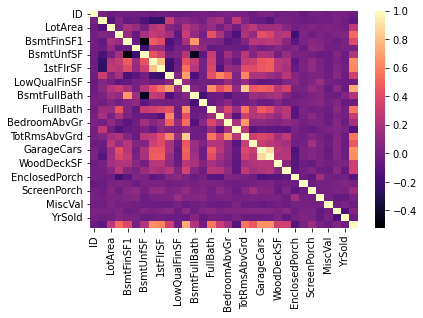

In [302]:
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization

# Check correlation - but what do I do if correlation is high?
sb.heatmap(train_data.corr(), cmap = 'magma')
plt.savefig('heatmap.png', format='png')
plt.show()

## 1.2 Check data types

In [303]:
# Check data types for categoricals
categoricals_train = set(train_data.dtypes[train_data.dtypes=='object'].index)
categoricals_test = set(train_data.dtypes[train_data.dtypes=='object'].index)

print(categoricals_train-categoricals_test) # Check if categorical sets different. 0 = no diffs.
print(categoricals_train) # Manual inspection tells me that OverallQual, YearBuilt, OverallCond need to change their dtypes from strings/objects to numerical


set()
{'Street', 'ExterQual', 'OverallQual', 'OverallCond', 'BldgType', 'HouseStyle', 'LotConfig', 'YearBuilt'}


## 1.3 Inspect outliers

In [304]:
import matplotlib.pyplot as plt
import math

def plot_custom_subplot(df_obj, y_series, num_cols=int(5), plot_type='scatter'):

    num_plots = len(df_obj.columns)
    num_rows = math.ceil(num_plots/num_cols)
    fig, ax_array =  plt.subplots(num_rows, num_cols, figsize=(100/2.54, 120/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        for axes in ax_row:
            axes.set_xlabel(df_obj.columns[k])
            if plot_type == 'scatter':
                axes.scatter(df_obj.iloc[:, k], y_series)
            elif plot_type == 'histogram':
                axes.hist(df_obj.iloc[:, k])
            k += 1
            if k == num_plots:
                break
    
    plt.show()    
    plt.savefig('train_data_' + plot_type + '.png', format='png')

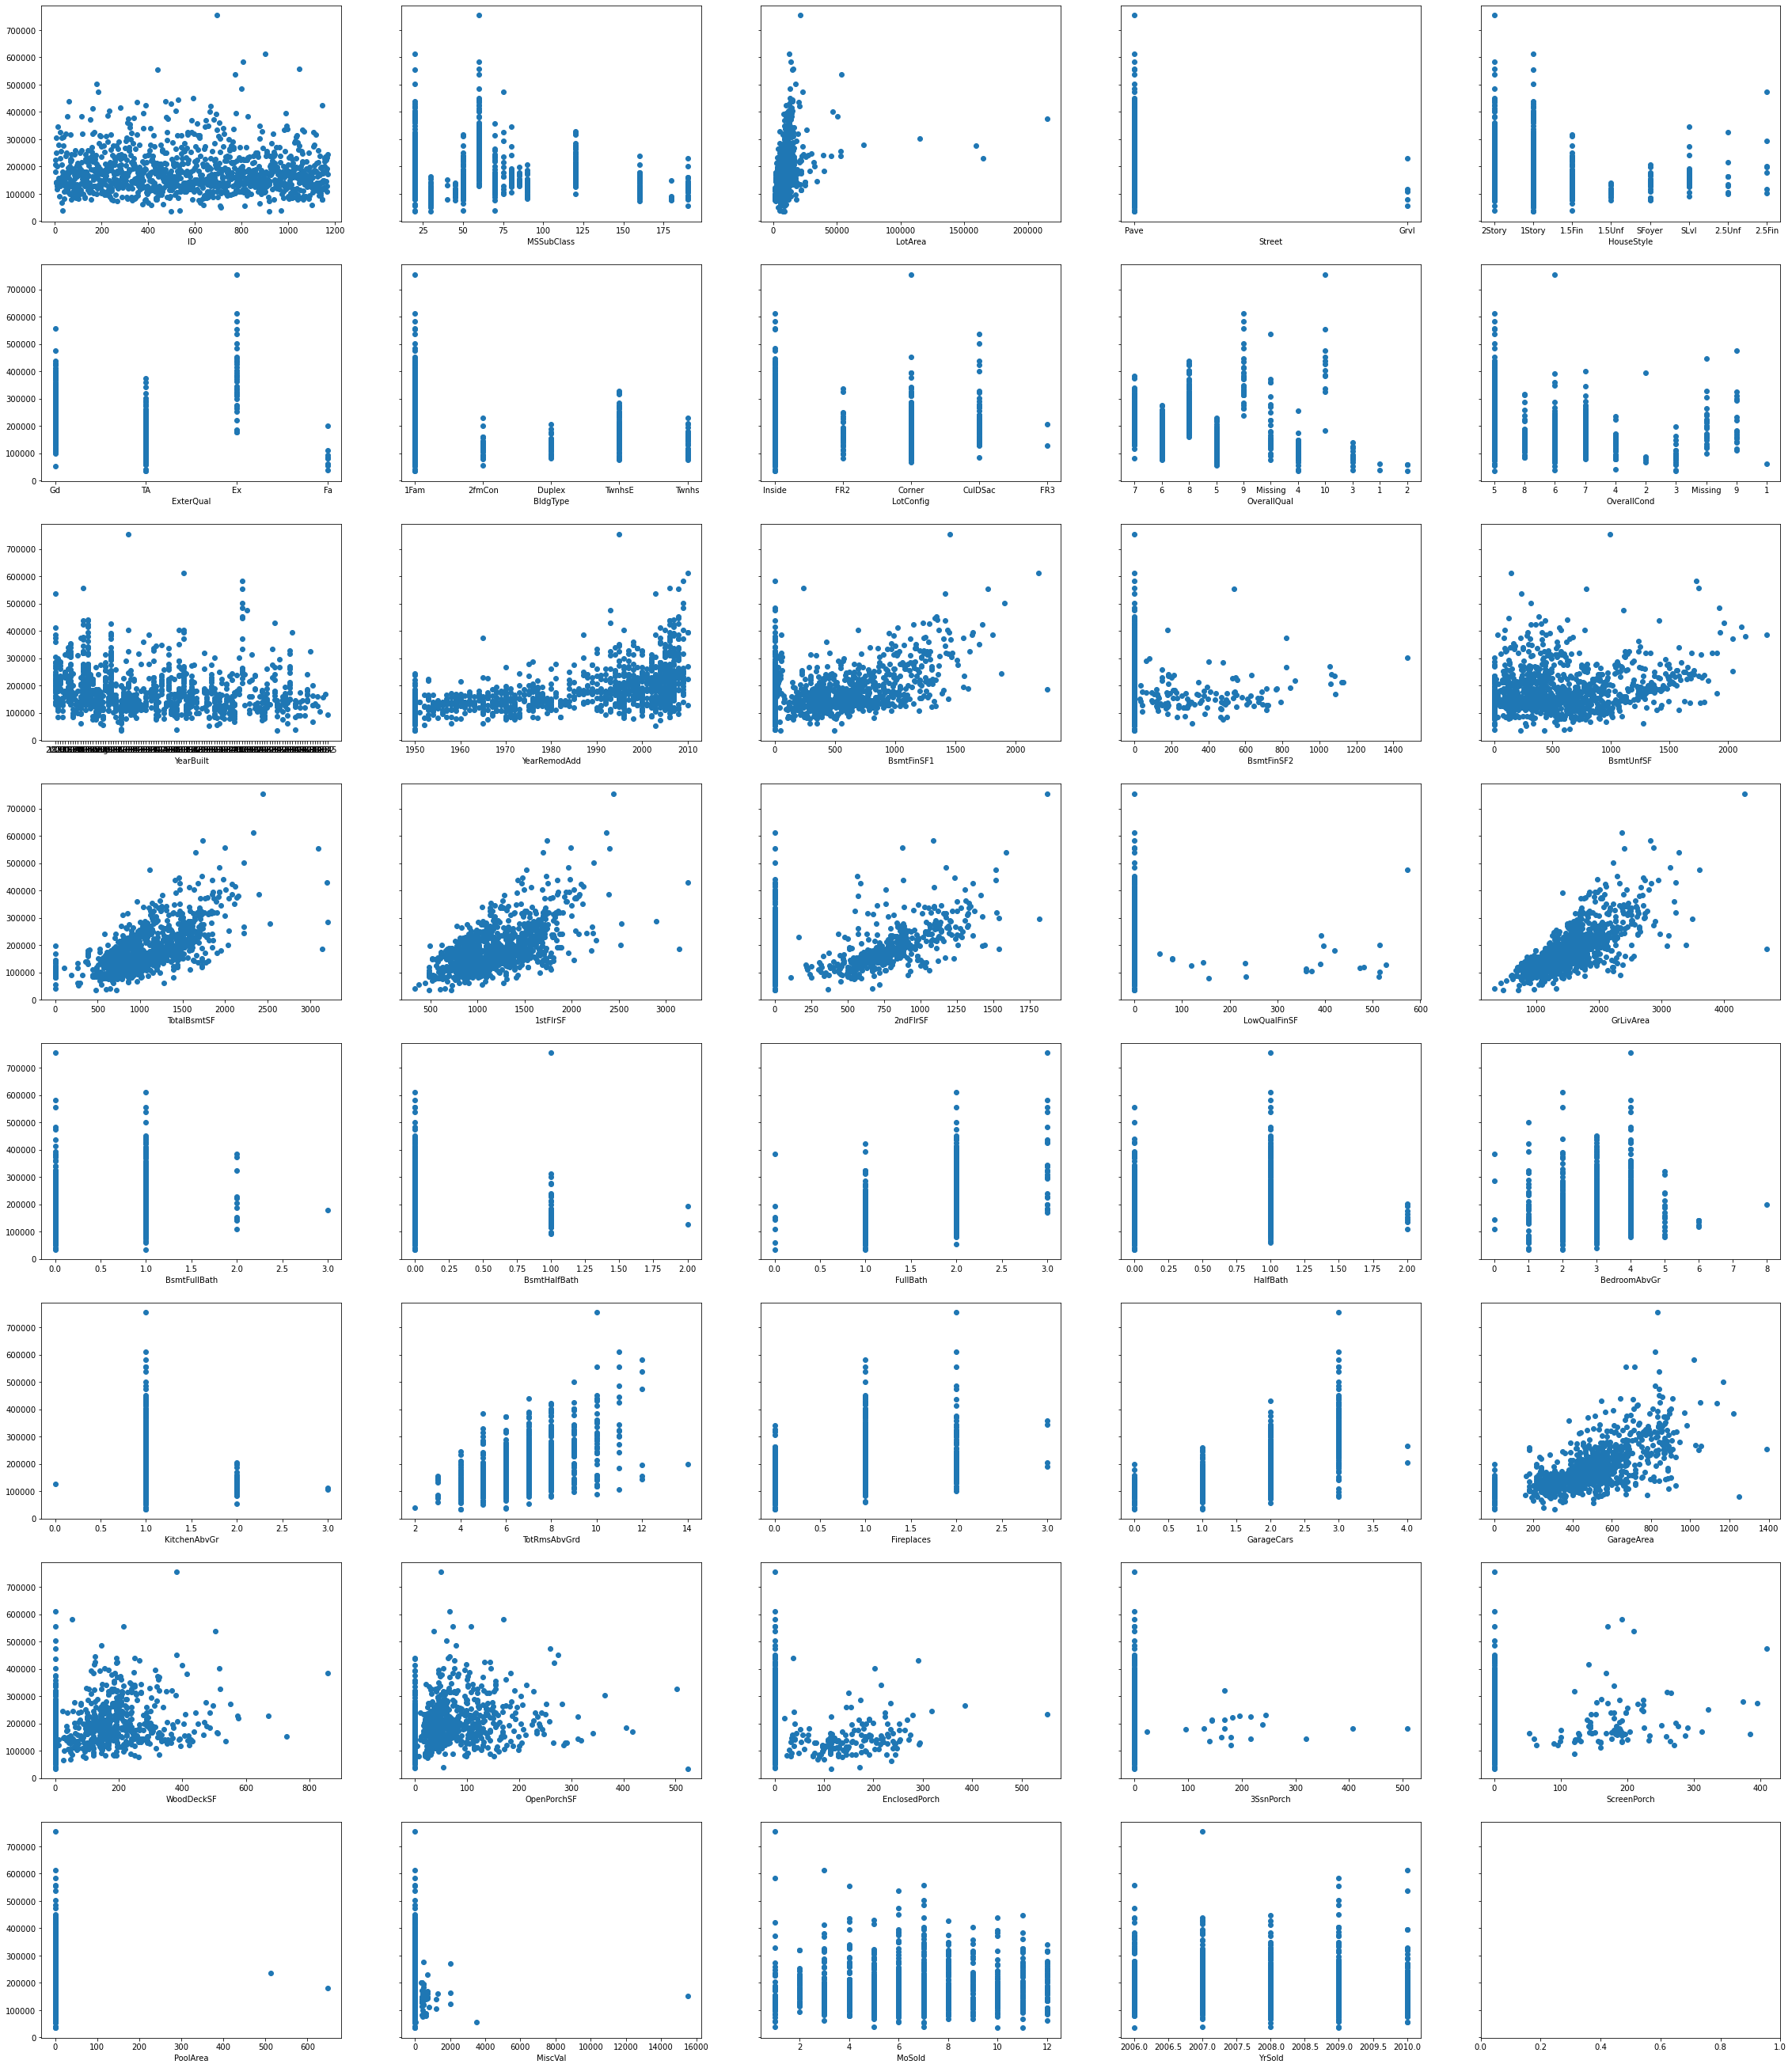

<Figure size 432x288 with 0 Axes>

In [305]:
# Check scatter
plot_custom_subplot(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

## 1.4 Inspect skew

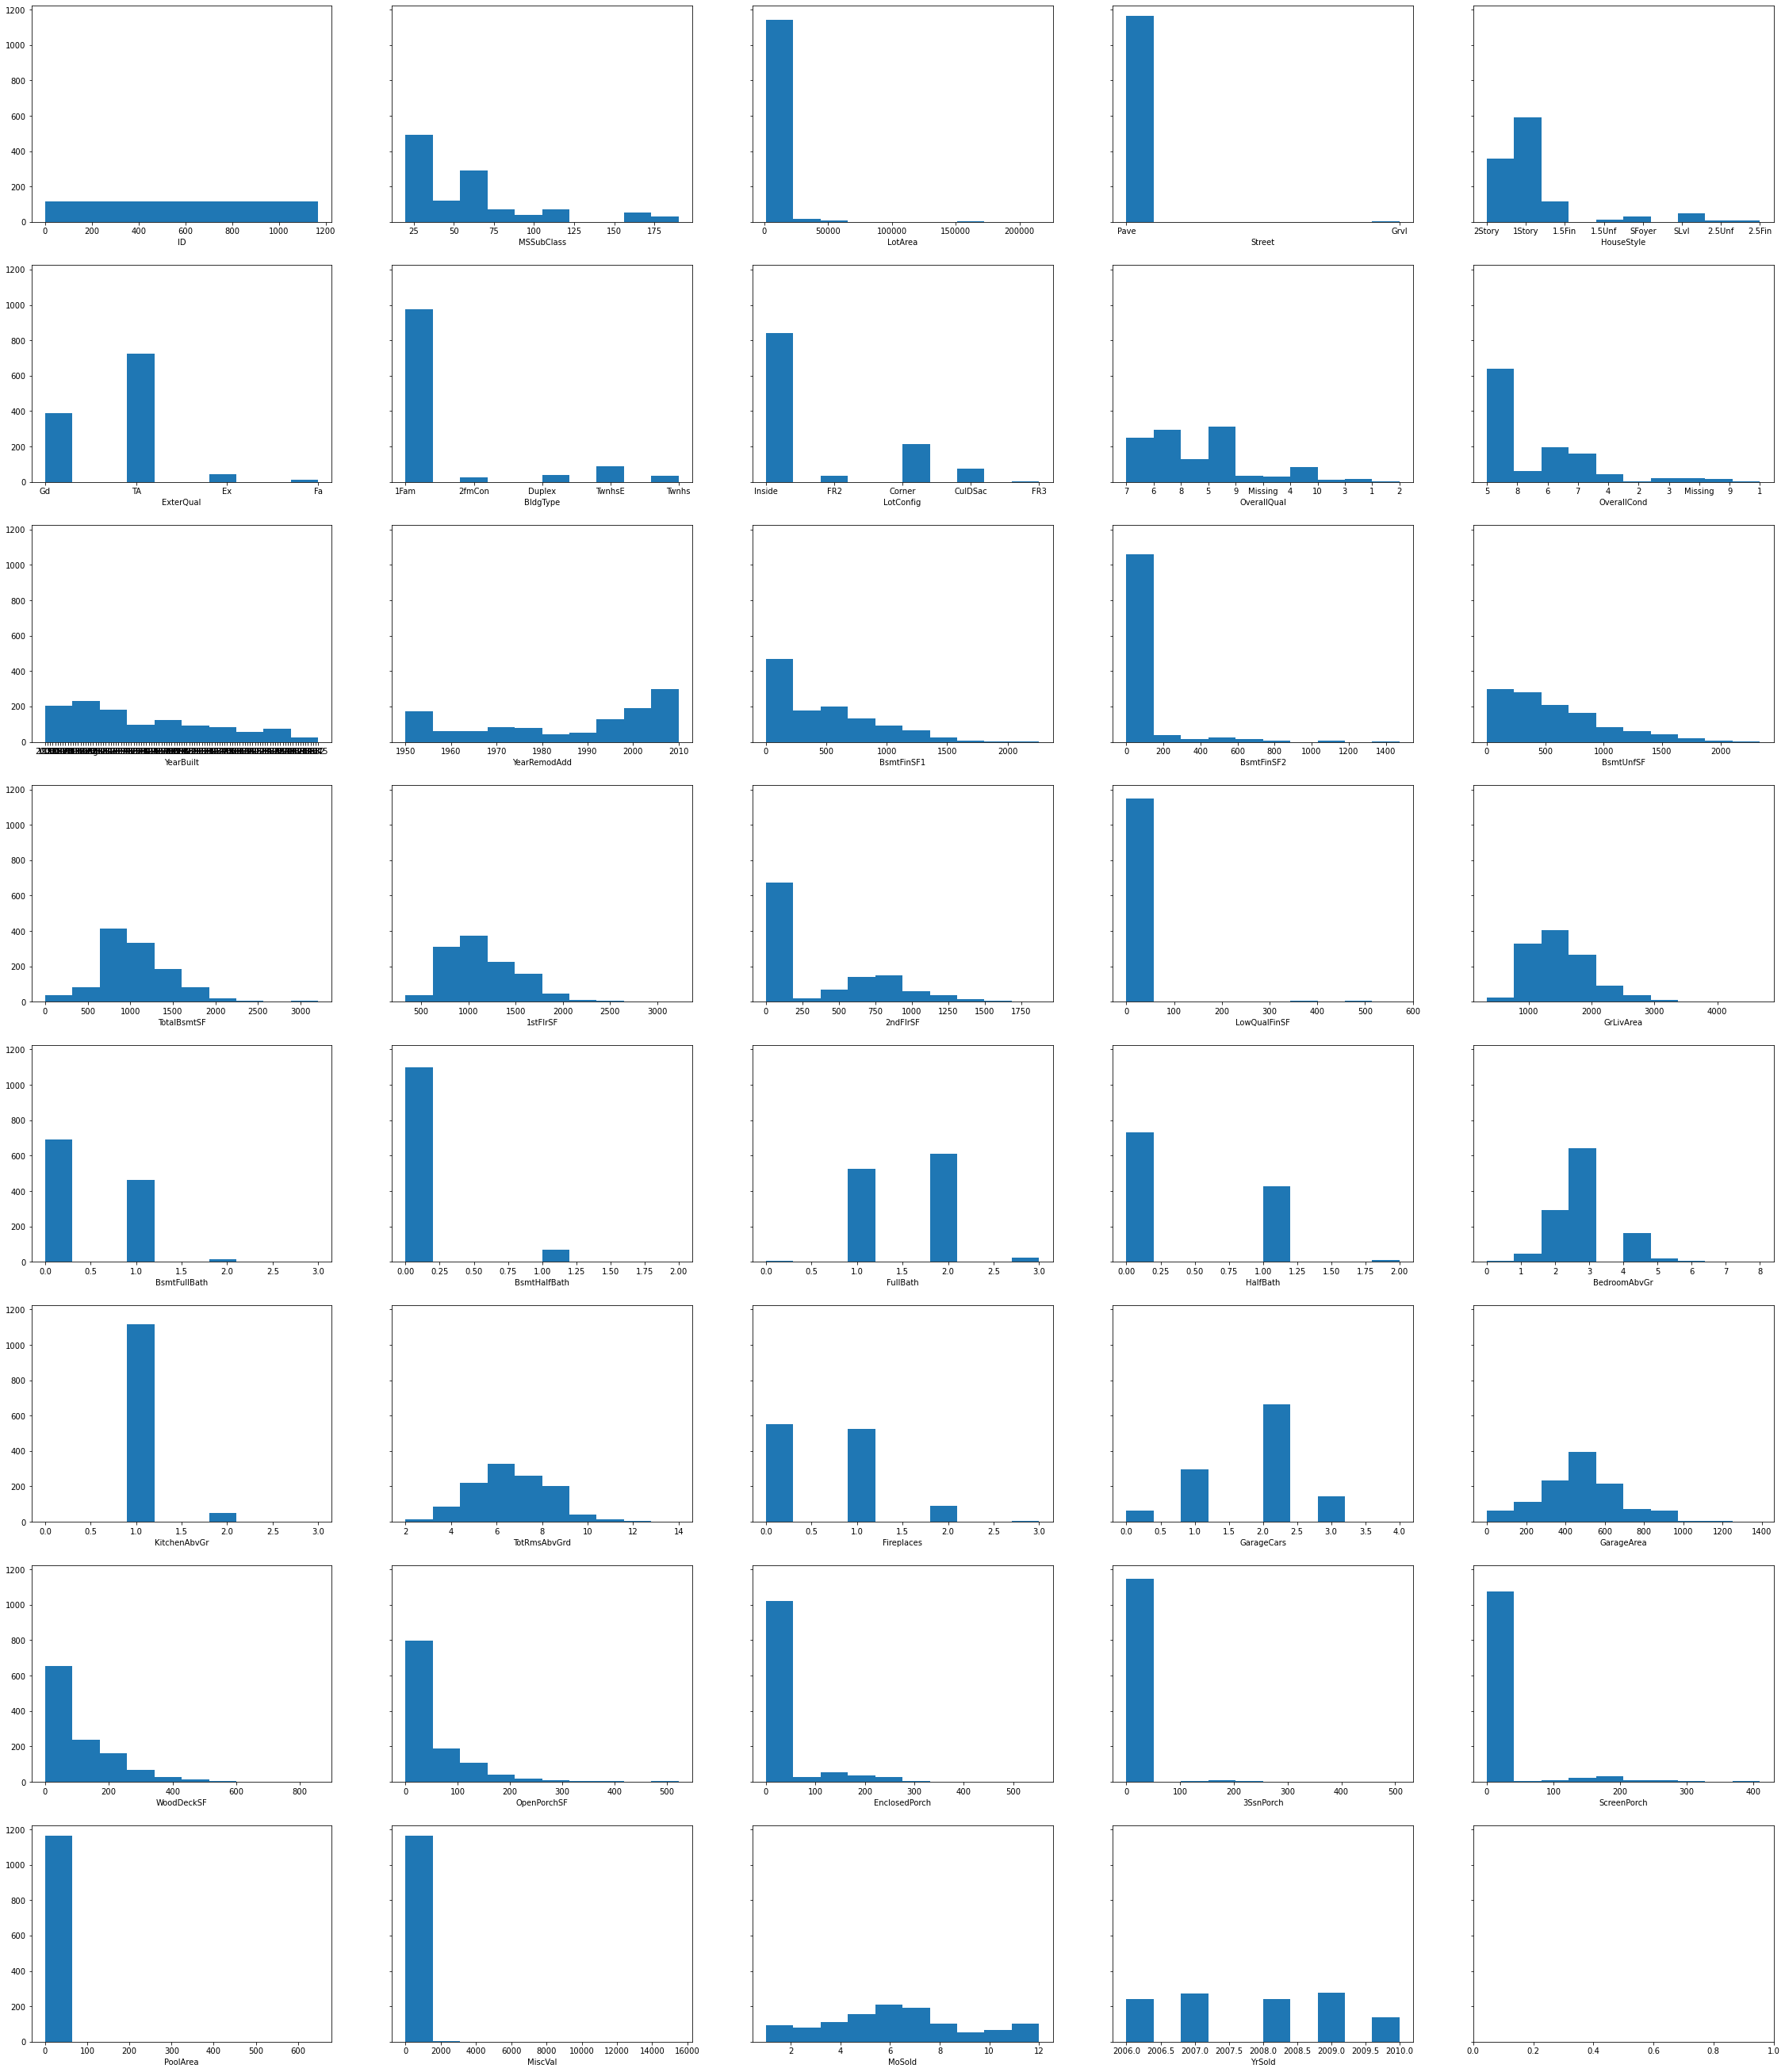

<Figure size 432x288 with 0 Axes>

In [306]:
# Check feature distribution
plot_custom_subplot(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'], plot_type='histogram')

1.7487112596222822


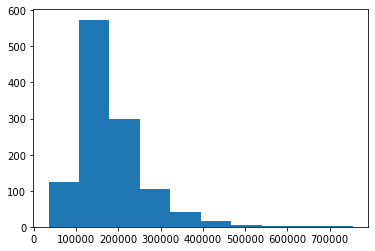

In [307]:
# Check sale price distribution
plt.hist(train_data['SalePrice'])
print(train_data['SalePrice'].skew())


In [308]:
# check skew
# from scipy.stats import shapiro
# print(shapiro(train_data['SalePrice'])) # Formal skew check

num_feats = train_data.dtypes[train_data.dtypes!='object'].index
skew_feats = train_data[num_feats].skew().sort_values(ascending=False)
print(skew_feats)

MiscVal          27.966380
PoolArea         24.623340
LotArea          12.240663
3SsnPorch        10.208476
LowQualFinSF      8.684560
KitchenAbvGr      4.596279
BsmtFinSF2        4.313216
BsmtHalfBath      3.948249
ScreenPorch       3.936139
EnclosedPorch     3.168149
OpenPorchSF       2.292215
SalePrice         1.748711
WoodDeckSF        1.484201
MSSubClass        1.410259
GrLivArea         1.078755
1stFlrSF          0.963637
BsmtUnfSF         0.951956
2ndFlrSF          0.815896
BsmtFinSF1        0.789096
TotRmsAbvGrd      0.672153
HalfBath          0.659175
Fireplaces        0.645413
BsmtFullBath      0.642196
TotalBsmtSF       0.563757
BedroomAbvGr      0.290898
MoSold            0.199846
GarageArea        0.097302
YrSold            0.095714
FullBath          0.048092
ID                0.000000
GarageCars       -0.389608
YearRemodAdd     -0.520319
dtype: float64


# 2.Process the data

In [309]:
# Rename columns
train_data_temp.rename({'YearRemodAd': 'YearSinceRemodAdd'}, axis=1, inplace=True)

## 2.1 Impute or drop 'Missing' data

In [310]:
def get_cols_with_missing(dfObj, value:"Missing") -> list:
    """Return list of the columns that equal the value."""

    listCols = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listCols.append(col)

    unique_cols = np.unique(listCols)
    return unique_cols

train_cols_with_missing = get_cols_with_missing(train_data, "Missing")
print(train_cols_with_missing)

test_cols_with_missing = get_cols_with_missing(test_data, "Missing")
print(test_cols_with_missing)

['OverallCond' 'OverallQual' 'YearBuilt']
['OverallCond' 'OverallQual' 'YearBuilt']


In [311]:
def replace_missing_with_mean(df, cols_with_missing:list):
    """Replace the fields in the dataframe object with the mean of that column."""

    df_copy = df.copy()

    df_copy.replace(to_replace="Missing", value=np.nan, inplace=True)

    # df_object['OverallQual'].mean() didnt' work because data type not number. Write it up in the report.
    # df_object['OverallQual'].dtypes #dtype('O') is a string

    for col in cols_with_missing:
        df_copy[col] = df_copy[col].astype('float') # because NaN is a float and mean() requires same data type
        df_copy[col].fillna(value=df_copy[col].mean(), inplace=True) 
        df_copy[col] = df_copy[col].astype('int') # linear regression only supports int type
    
    return df_copy

In [312]:
def get_rows_with_missing_data(df_object, cols_with_missing:list):
    """Find row if it contains 'Missing' in any of the columns in cols_with_missing."""

    rows_with_missing = []
    for index, row in df_object.iterrows():
        # If the row contains at least one 'Missing' then append to the list
        num_missing = 0
        for col in cols_with_missing:
            if row[col] == 'Missing':
                num_missing += 1
        if num_missing > 0:
            rows_with_missing.append(row)

    return rows_with_missing


In [313]:
train_rows_with_missing = get_rows_with_missing_data(train_data, train_cols_with_missing)
test_rows_with_missing = get_rows_with_missing_data(test_data, test_cols_with_missing)

print(f'Train.csv has {len(train_rows_with_missing)} rows with \'Missing\' data out of {len(train_data)}.')
print(f'Test.csv has {len(test_rows_with_missing)} rows with \'Missing\' data out of {len(test_data)}.')

Train.csv has 66 rows with 'Missing' data out of 1168.
Test.csv has 15 rows with 'Missing' data out of 292.


In [314]:
def drop_rows(df):
    """Drops rows if the columns OverallCond, OverallQual of YearBuilt contain 'Missing'."""
    df_subset = df[(df['OverallCond'] != 'Missing') & (df['OverallQual'] != 'Missing') & (df['YearBuilt'] !='Missing')] 
    return df_subset

In [315]:
def fix_missing_data(df, missing_data_treatment='mean'):
    if missing_data_treatment =='mean': # impute
        cols_with_missing = get_cols_with_missing(df, "Missing")
        df_fixed = replace_missing_with_mean(df, cols_with_missing)
    if missing_data_treatment =='drop':
        df_fixed = drop_rows(df)
    return df_fixed

In [316]:
train_imputed = fix_missing_data(train_data, 'mean')
train_dropped = fix_missing_data(train_data, 'drop')

test_imputed = fix_missing_data(test_data, 'mean')
test_dropped = fix_missing_data(test_data, 'drop')

print(test_dropped)

      ID  MSSubClass  LotArea Street HouseStyle ExterQual BldgType LotConfig  \
0      1          70    13728   Pave     2Story        TA     1Fam    Corner   
1      2          60    35760   Pave     2Story        Gd     1Fam   CulDSac   
3      4          20     9120   Pave     1Story        TA     1Fam    Inside   
4      5         160     4017   Pave     2Story        Gd   TwnhsE    Inside   
5      6          50    18030   Pave     1.5Fin        TA     1Fam    Inside   
..   ...         ...      ...    ...        ...       ...      ...       ...   
287  288          60     7917   Pave     2Story        TA     1Fam    Inside   
288  289          20    13175   Pave     1Story        TA     1Fam    Inside   
289  290          70     9042   Pave     2Story        Ex     1Fam    Inside   
290  291          20     9717   Pave     1Story        TA     1Fam    Inside   
291  292          20     9937   Pave     1Story        Gd     1Fam    Inside   

    OverallQual OverallCond  ... WoodDe

In [317]:
# Sanity check
print(len(train_imputed))
print(len(train_dropped))

# Sanity check
print(len(test_imputed))
print(len(test_dropped))

1168
1102
292
277


## 2.2 Change dtypes to numerical


In [318]:
def change_dtype(df):
    df = df.astype({'OverallCond': int})
    df = df.astype({'OverallQual': int})
    df = df.astype({'YearBuilt': int})
    return df

In [319]:
train_imputed = change_dtype(train_imputed)
train_dropped = change_dtype(train_dropped)

test_imputed = change_dtype(test_imputed)
test_dropped = change_dtype(test_dropped)

print(test_dropped)

      ID  MSSubClass  LotArea Street HouseStyle ExterQual BldgType LotConfig  \
0      1          70    13728   Pave     2Story        TA     1Fam    Corner   
1      2          60    35760   Pave     2Story        Gd     1Fam   CulDSac   
3      4          20     9120   Pave     1Story        TA     1Fam    Inside   
4      5         160     4017   Pave     2Story        Gd   TwnhsE    Inside   
5      6          50    18030   Pave     1.5Fin        TA     1Fam    Inside   
..   ...         ...      ...    ...        ...       ...      ...       ...   
287  288          60     7917   Pave     2Story        TA     1Fam    Inside   
288  289          20    13175   Pave     1Story        TA     1Fam    Inside   
289  290          70     9042   Pave     2Story        Ex     1Fam    Inside   
290  291          20     9717   Pave     1Story        TA     1Fam    Inside   
291  292          20     9937   Pave     1Story        Gd     1Fam    Inside   

     OverallQual  OverallCond  ...  Woo

## 2.3 Change year data to years since

In [320]:
def change_year_data(train_data, test_data, current_year=2022):
    train_data['YearRemodAdd'] = current_year - train_data['YearRemodAdd']
    test_data['YearRemodAdd'] = current_year - test_data['YearRemodAdd']

    train_data['YearBuilt'] = current_year - train_data['YearBuilt']
    test_data['YearBuilt'] = current_year - test_data['YearBuilt']

    train_data['YrSold'] = current_year - train_data['YrSold']
    test_data['YrSold'] = current_year - test_data['YrSold']


In [321]:
change_year_data(train_dropped, test_dropped)
change_year_data(train_imputed, test_imputed)

## 2.4 Fix skew training data

In [322]:
from scipy.stats import boxcox

def unskew(df):
    df_copy = df.copy()
    lmbda_map = {} # store lambda values to later apply on test set
    for col_name, skew_value in skew_feats.iteritems():
        df_copy[col_name] += 1 # boxcox requires strictly > 0. Add 1 like boxcox1p.
        df_copy[col_name], lmbda_value = boxcox(df_copy[col_name], lmbda=None)
        lmbda_map.update({col_name: lmbda_value})
    return df_copy, lmbda_map


In [323]:
train_imputed_unskewed, train_imputed_unskewed_lmbda_map  = unskew(train_imputed)
train_dropped_unskewed, train_dropped_unskewed_lmbda_map = unskew(train_dropped)

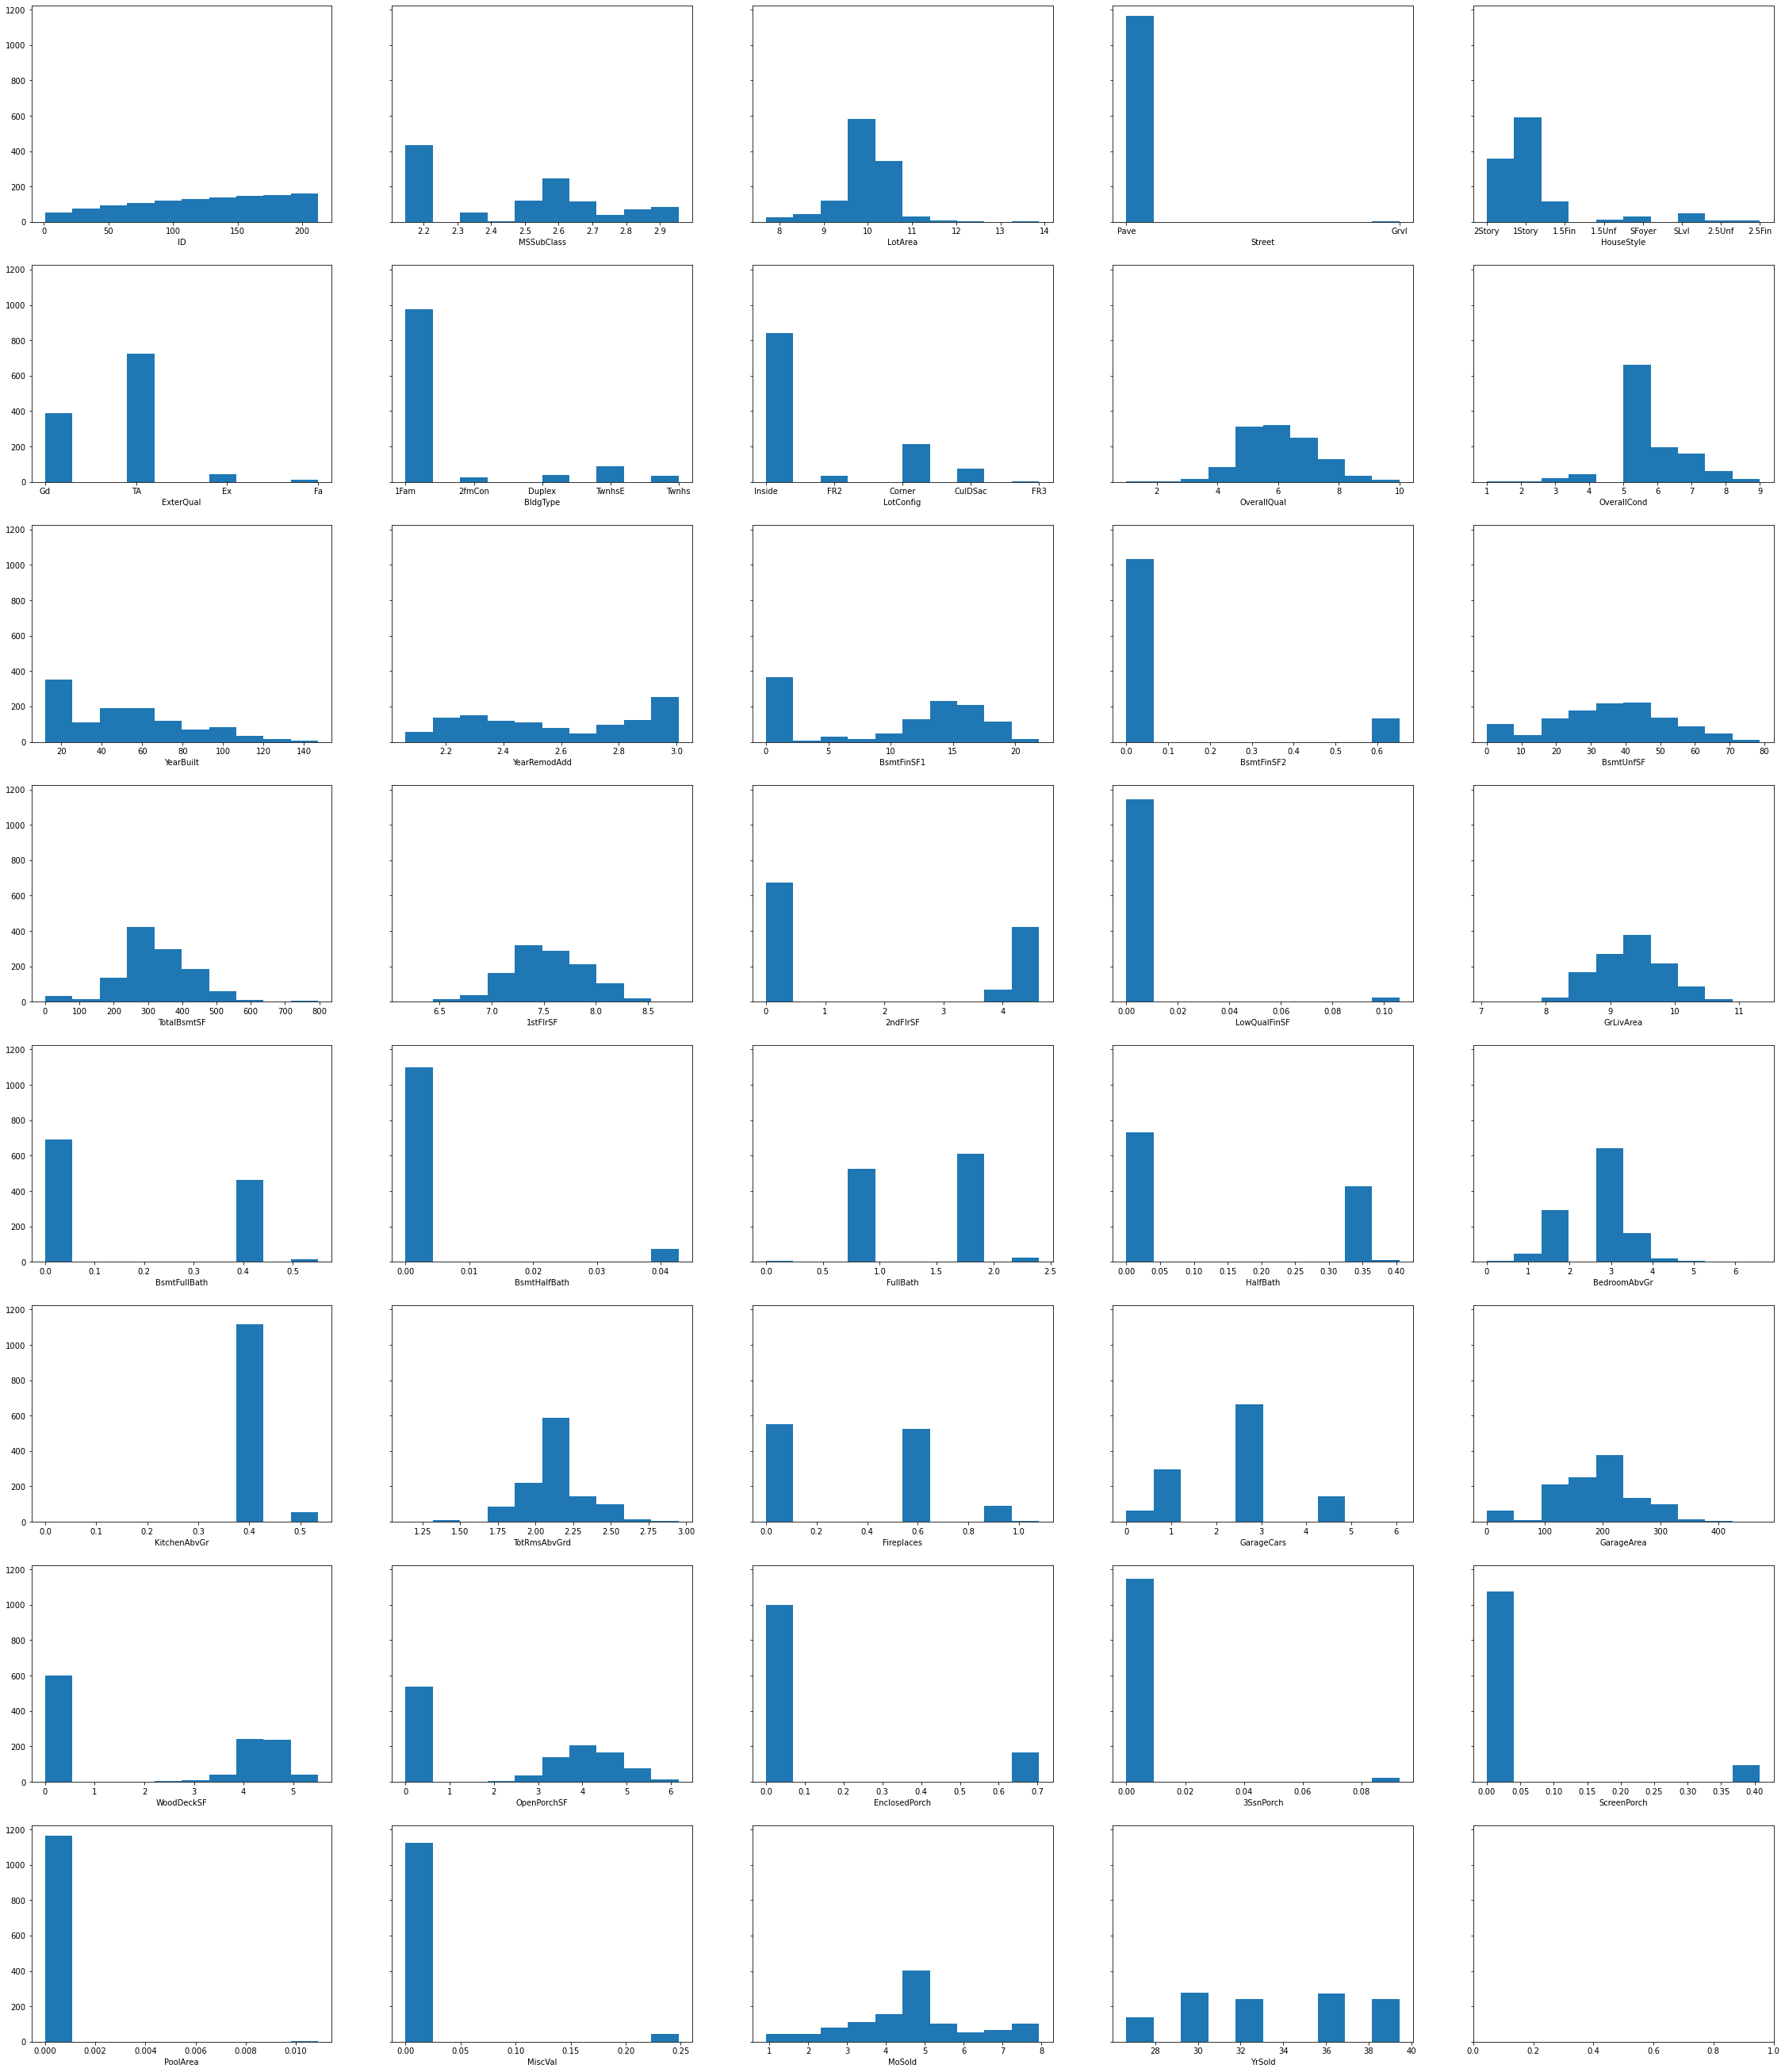

<Figure size 432x288 with 0 Axes>

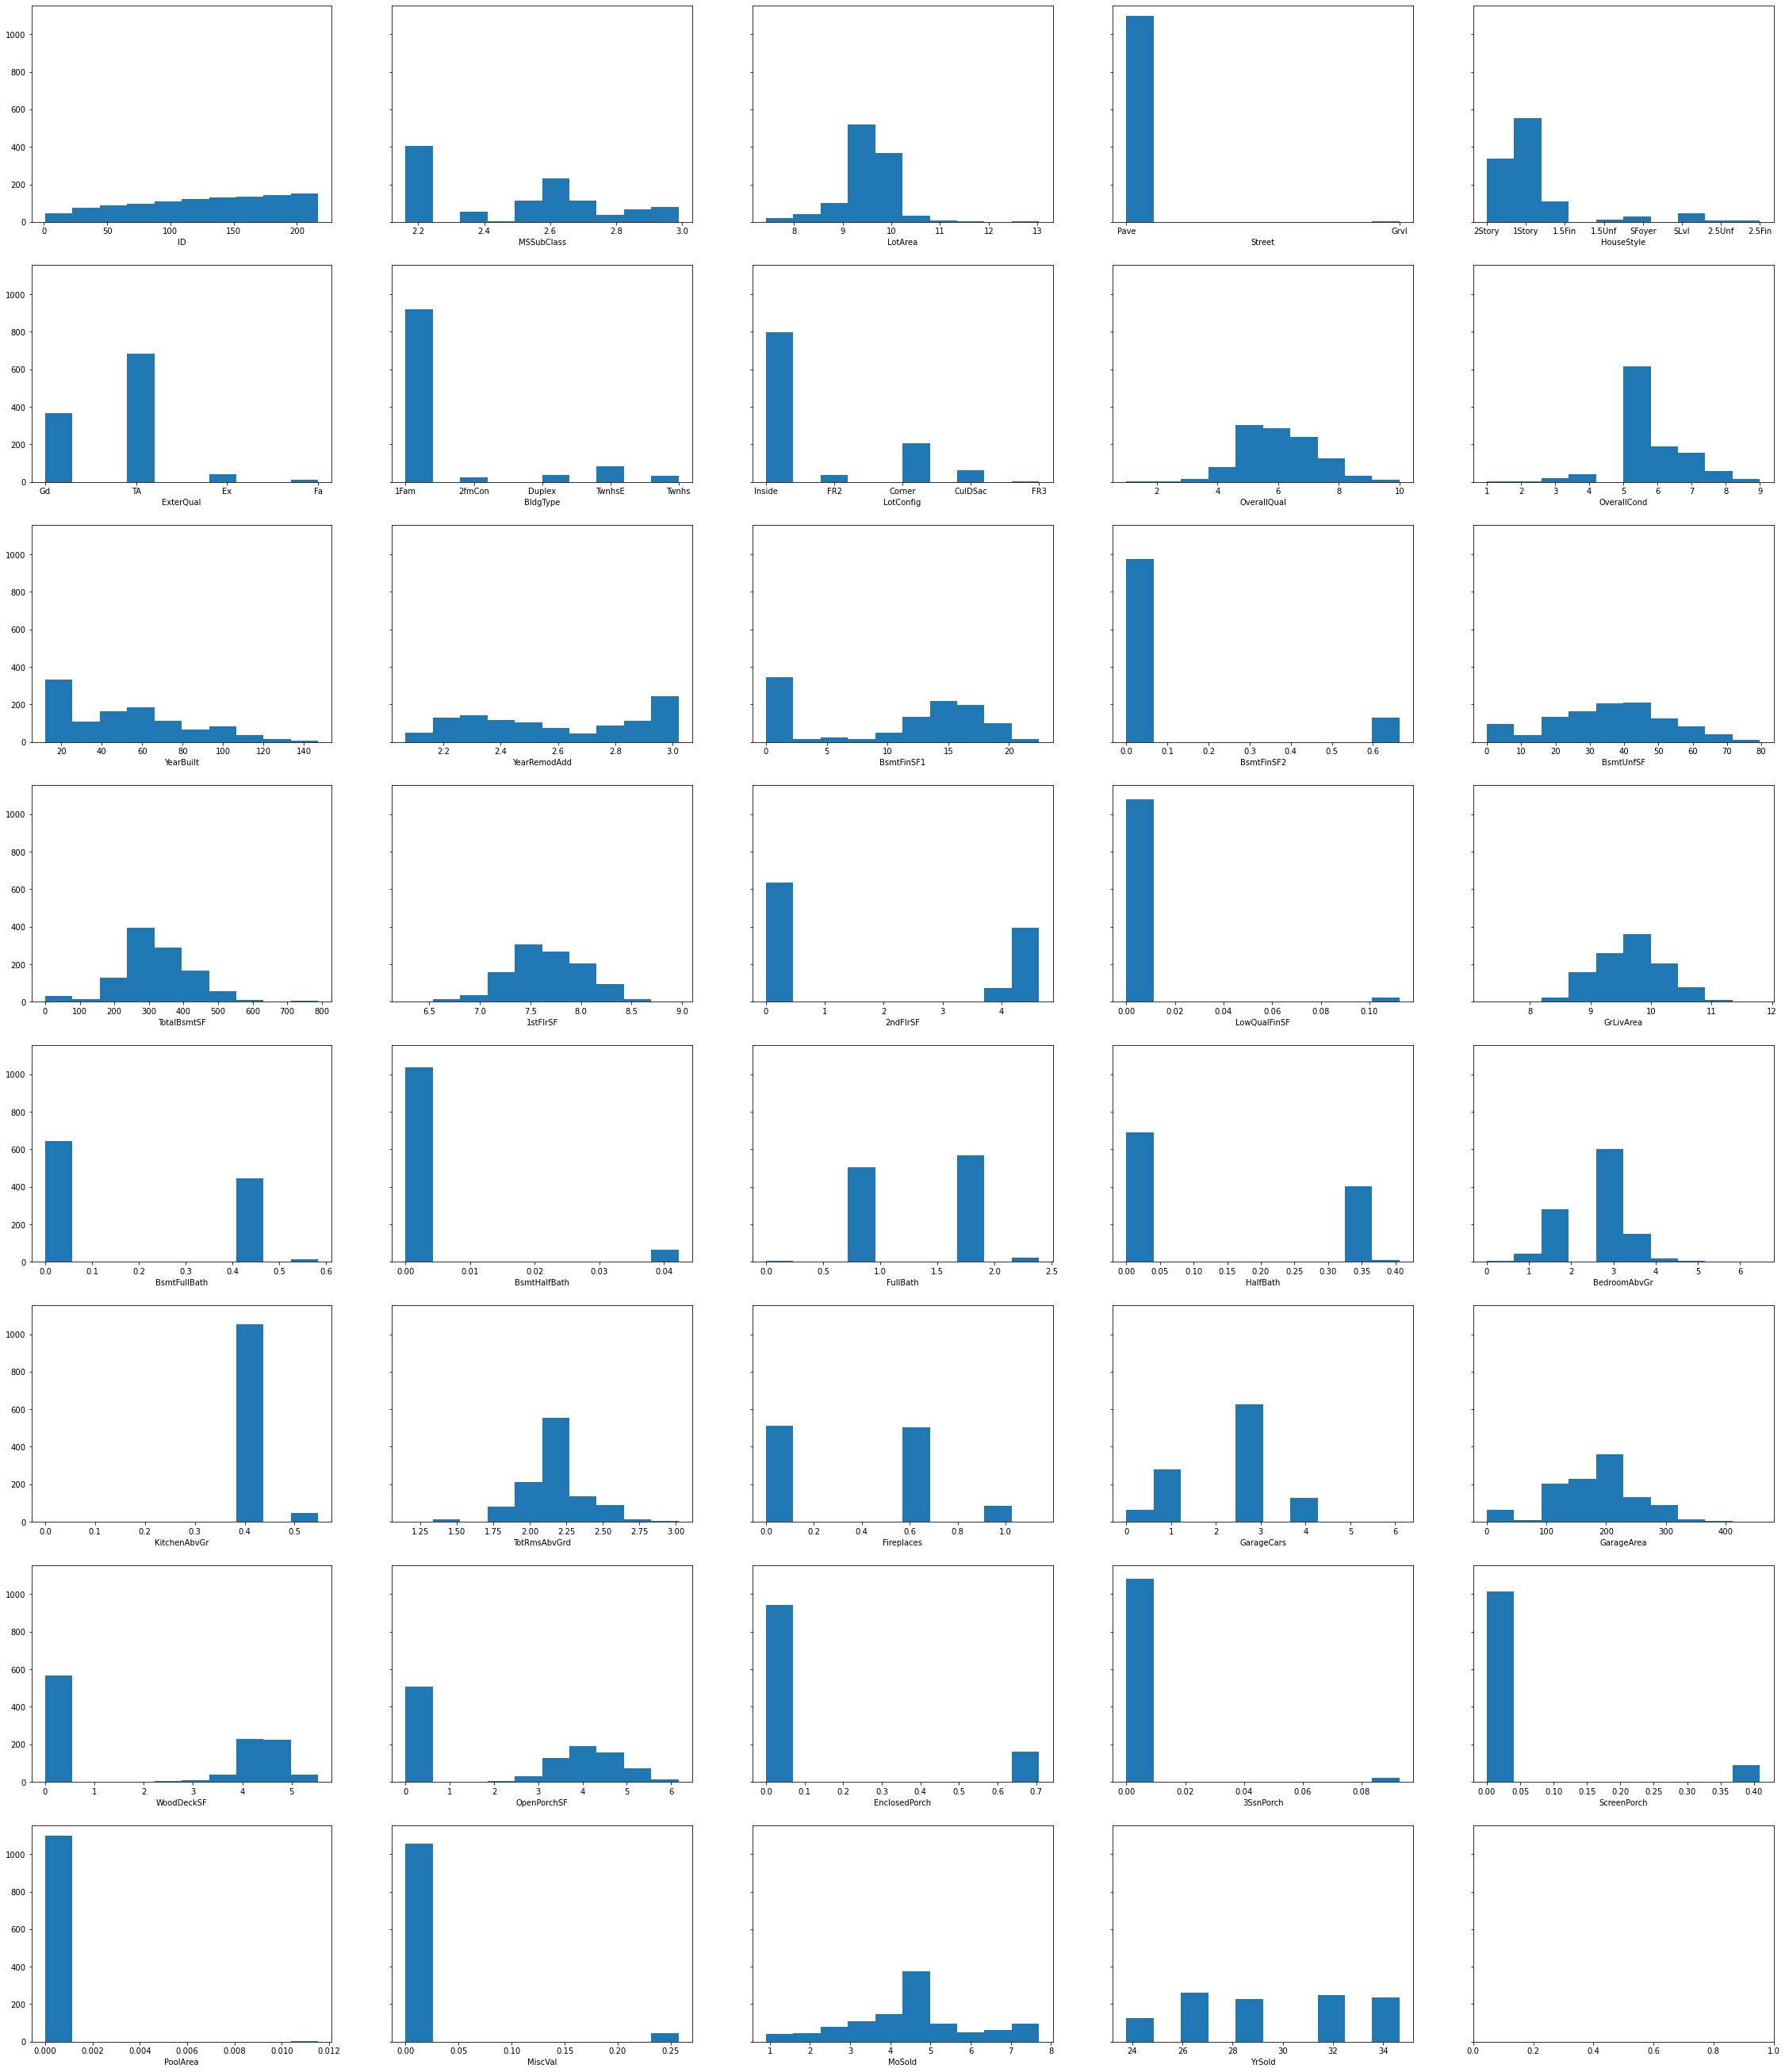

<Figure size 432x288 with 0 Axes>

In [324]:
plot_custom_subplot(train_imputed_unskewed.drop('SalePrice', axis = 1), train_imputed_unskewed['SalePrice'], plot_type='histogram')
plot_custom_subplot(train_dropped_unskewed.drop('SalePrice', axis = 1), train_dropped_unskewed['SalePrice'], plot_type='histogram')

(array([  5.,   8.,  28., 125., 330., 324., 186.,  75.,  16.,   5.]),
 array([ 8.57364489,  8.76543424,  8.95722359,  9.14901294,  9.34080229,
         9.53259164,  9.72438099,  9.91617034, 10.10795969, 10.29974903,
        10.49153838]),
 <BarContainer object of 10 artists>)

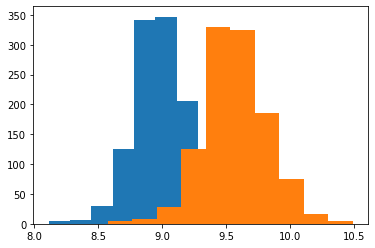

In [325]:
plt.hist(train_imputed_unskewed['SalePrice'])
plt.hist(train_dropped_unskewed['SalePrice'])

## 2.5 Fix skew test data

In [326]:
print(test_dropped)


      ID  MSSubClass  LotArea Street HouseStyle ExterQual BldgType LotConfig  \
0      1          70    13728   Pave     2Story        TA     1Fam    Corner   
1      2          60    35760   Pave     2Story        Gd     1Fam   CulDSac   
3      4          20     9120   Pave     1Story        TA     1Fam    Inside   
4      5         160     4017   Pave     2Story        Gd   TwnhsE    Inside   
5      6          50    18030   Pave     1.5Fin        TA     1Fam    Inside   
..   ...         ...      ...    ...        ...       ...      ...       ...   
287  288          60     7917   Pave     2Story        TA     1Fam    Inside   
288  289          20    13175   Pave     1Story        TA     1Fam    Inside   
289  290          70     9042   Pave     2Story        Ex     1Fam    Inside   
290  291          20     9717   Pave     1Story        TA     1Fam    Inside   
291  292          20     9937   Pave     1Story        Gd     1Fam    Inside   

     OverallQual  OverallCond  ...  Woo

In [327]:
def apply_lmbda_to_test(df, lmbda_dict):
    df_copy = df.copy()
    for key, value in lmbda_dict.items():
        df_copy[key] += 1 # boxcox requires strictly > 0. Add 1 like boxcox1p. TODO: Invalid for scores out of 10?
        df_copy[key] = boxcox(df_copy[key], lmbda=value)
    return df_copy

In [328]:
test_imputed_unskewed  = apply_lmbda_to_test(test_imputed, train_imputed_unskewed_lmbda_map)
test_dropped_unskewed = apply_lmbda_to_test(test_dropped, train_dropped_unskewed_lmbda_map )

In [329]:
print(test_dropped)


      ID  MSSubClass  LotArea Street HouseStyle ExterQual BldgType LotConfig  \
0      1          70    13728   Pave     2Story        TA     1Fam    Corner   
1      2          60    35760   Pave     2Story        Gd     1Fam   CulDSac   
3      4          20     9120   Pave     1Story        TA     1Fam    Inside   
4      5         160     4017   Pave     2Story        Gd   TwnhsE    Inside   
5      6          50    18030   Pave     1.5Fin        TA     1Fam    Inside   
..   ...         ...      ...    ...        ...       ...      ...       ...   
287  288          60     7917   Pave     2Story        TA     1Fam    Inside   
288  289          20    13175   Pave     1Story        TA     1Fam    Inside   
289  290          70     9042   Pave     2Story        Ex     1Fam    Inside   
290  291          20     9717   Pave     1Story        TA     1Fam    Inside   
291  292          20     9937   Pave     1Story        Gd     1Fam    Inside   

     OverallQual  OverallCond  ...  Woo

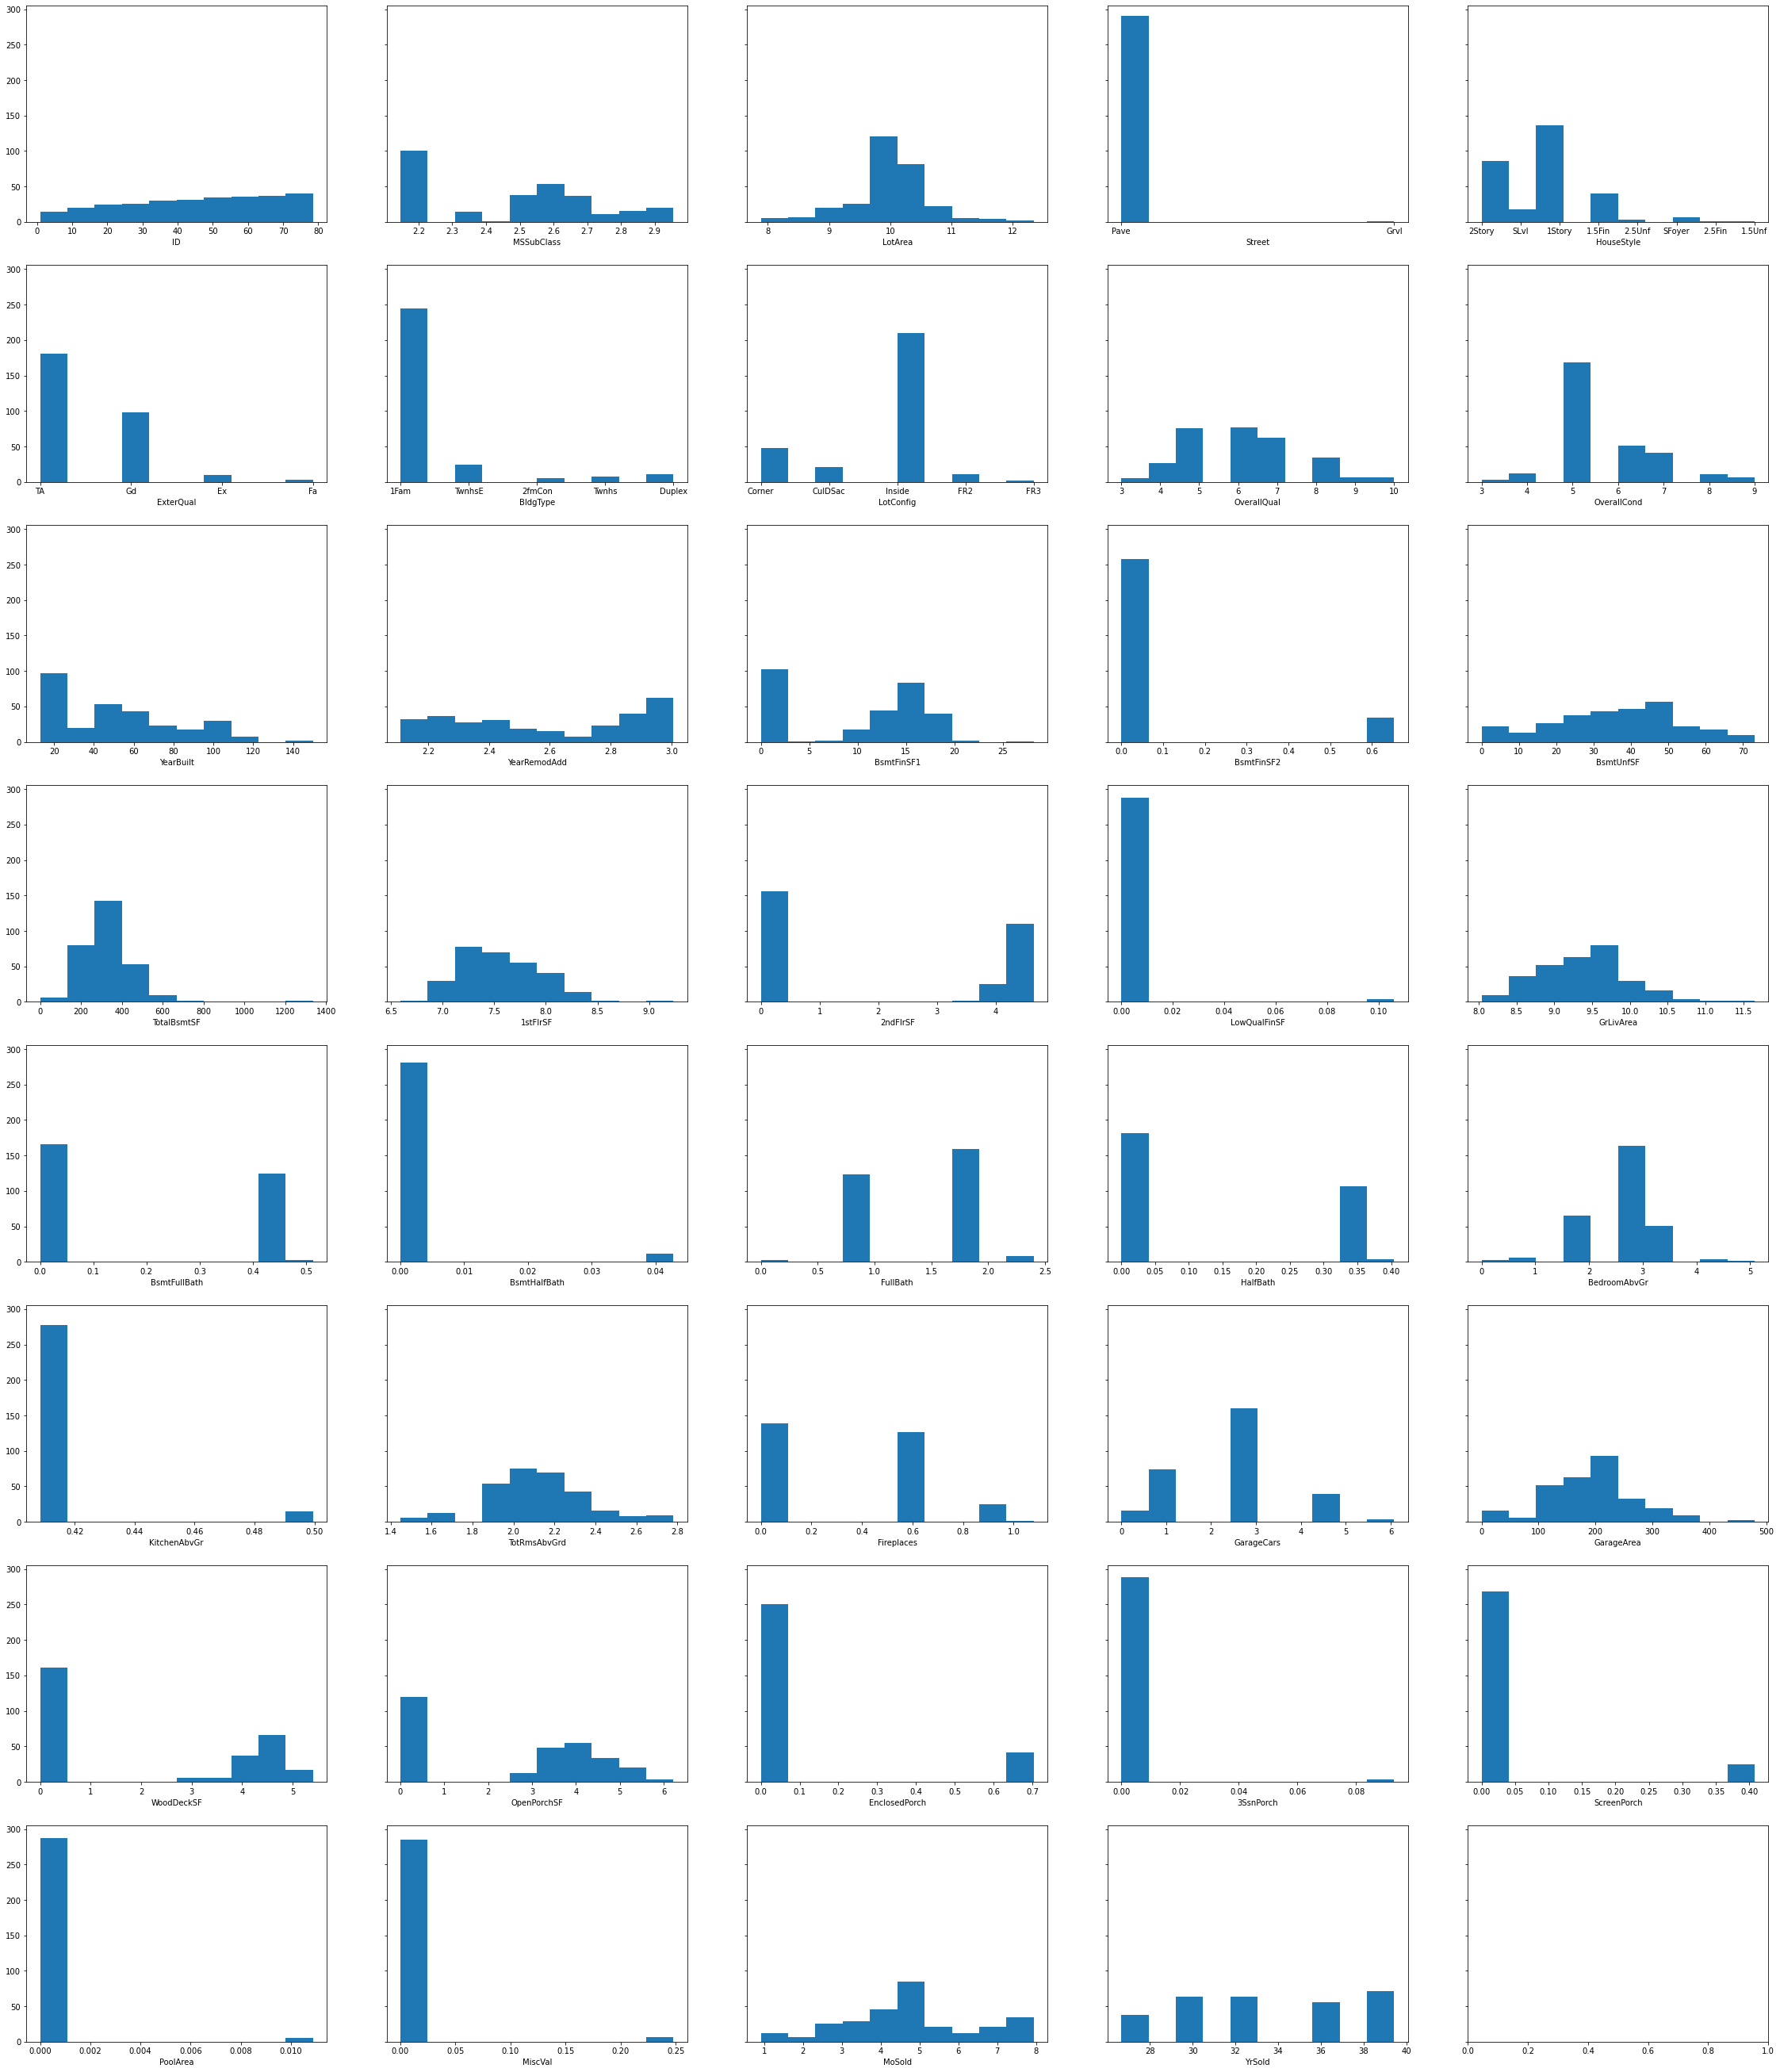

<Figure size 432x288 with 0 Axes>

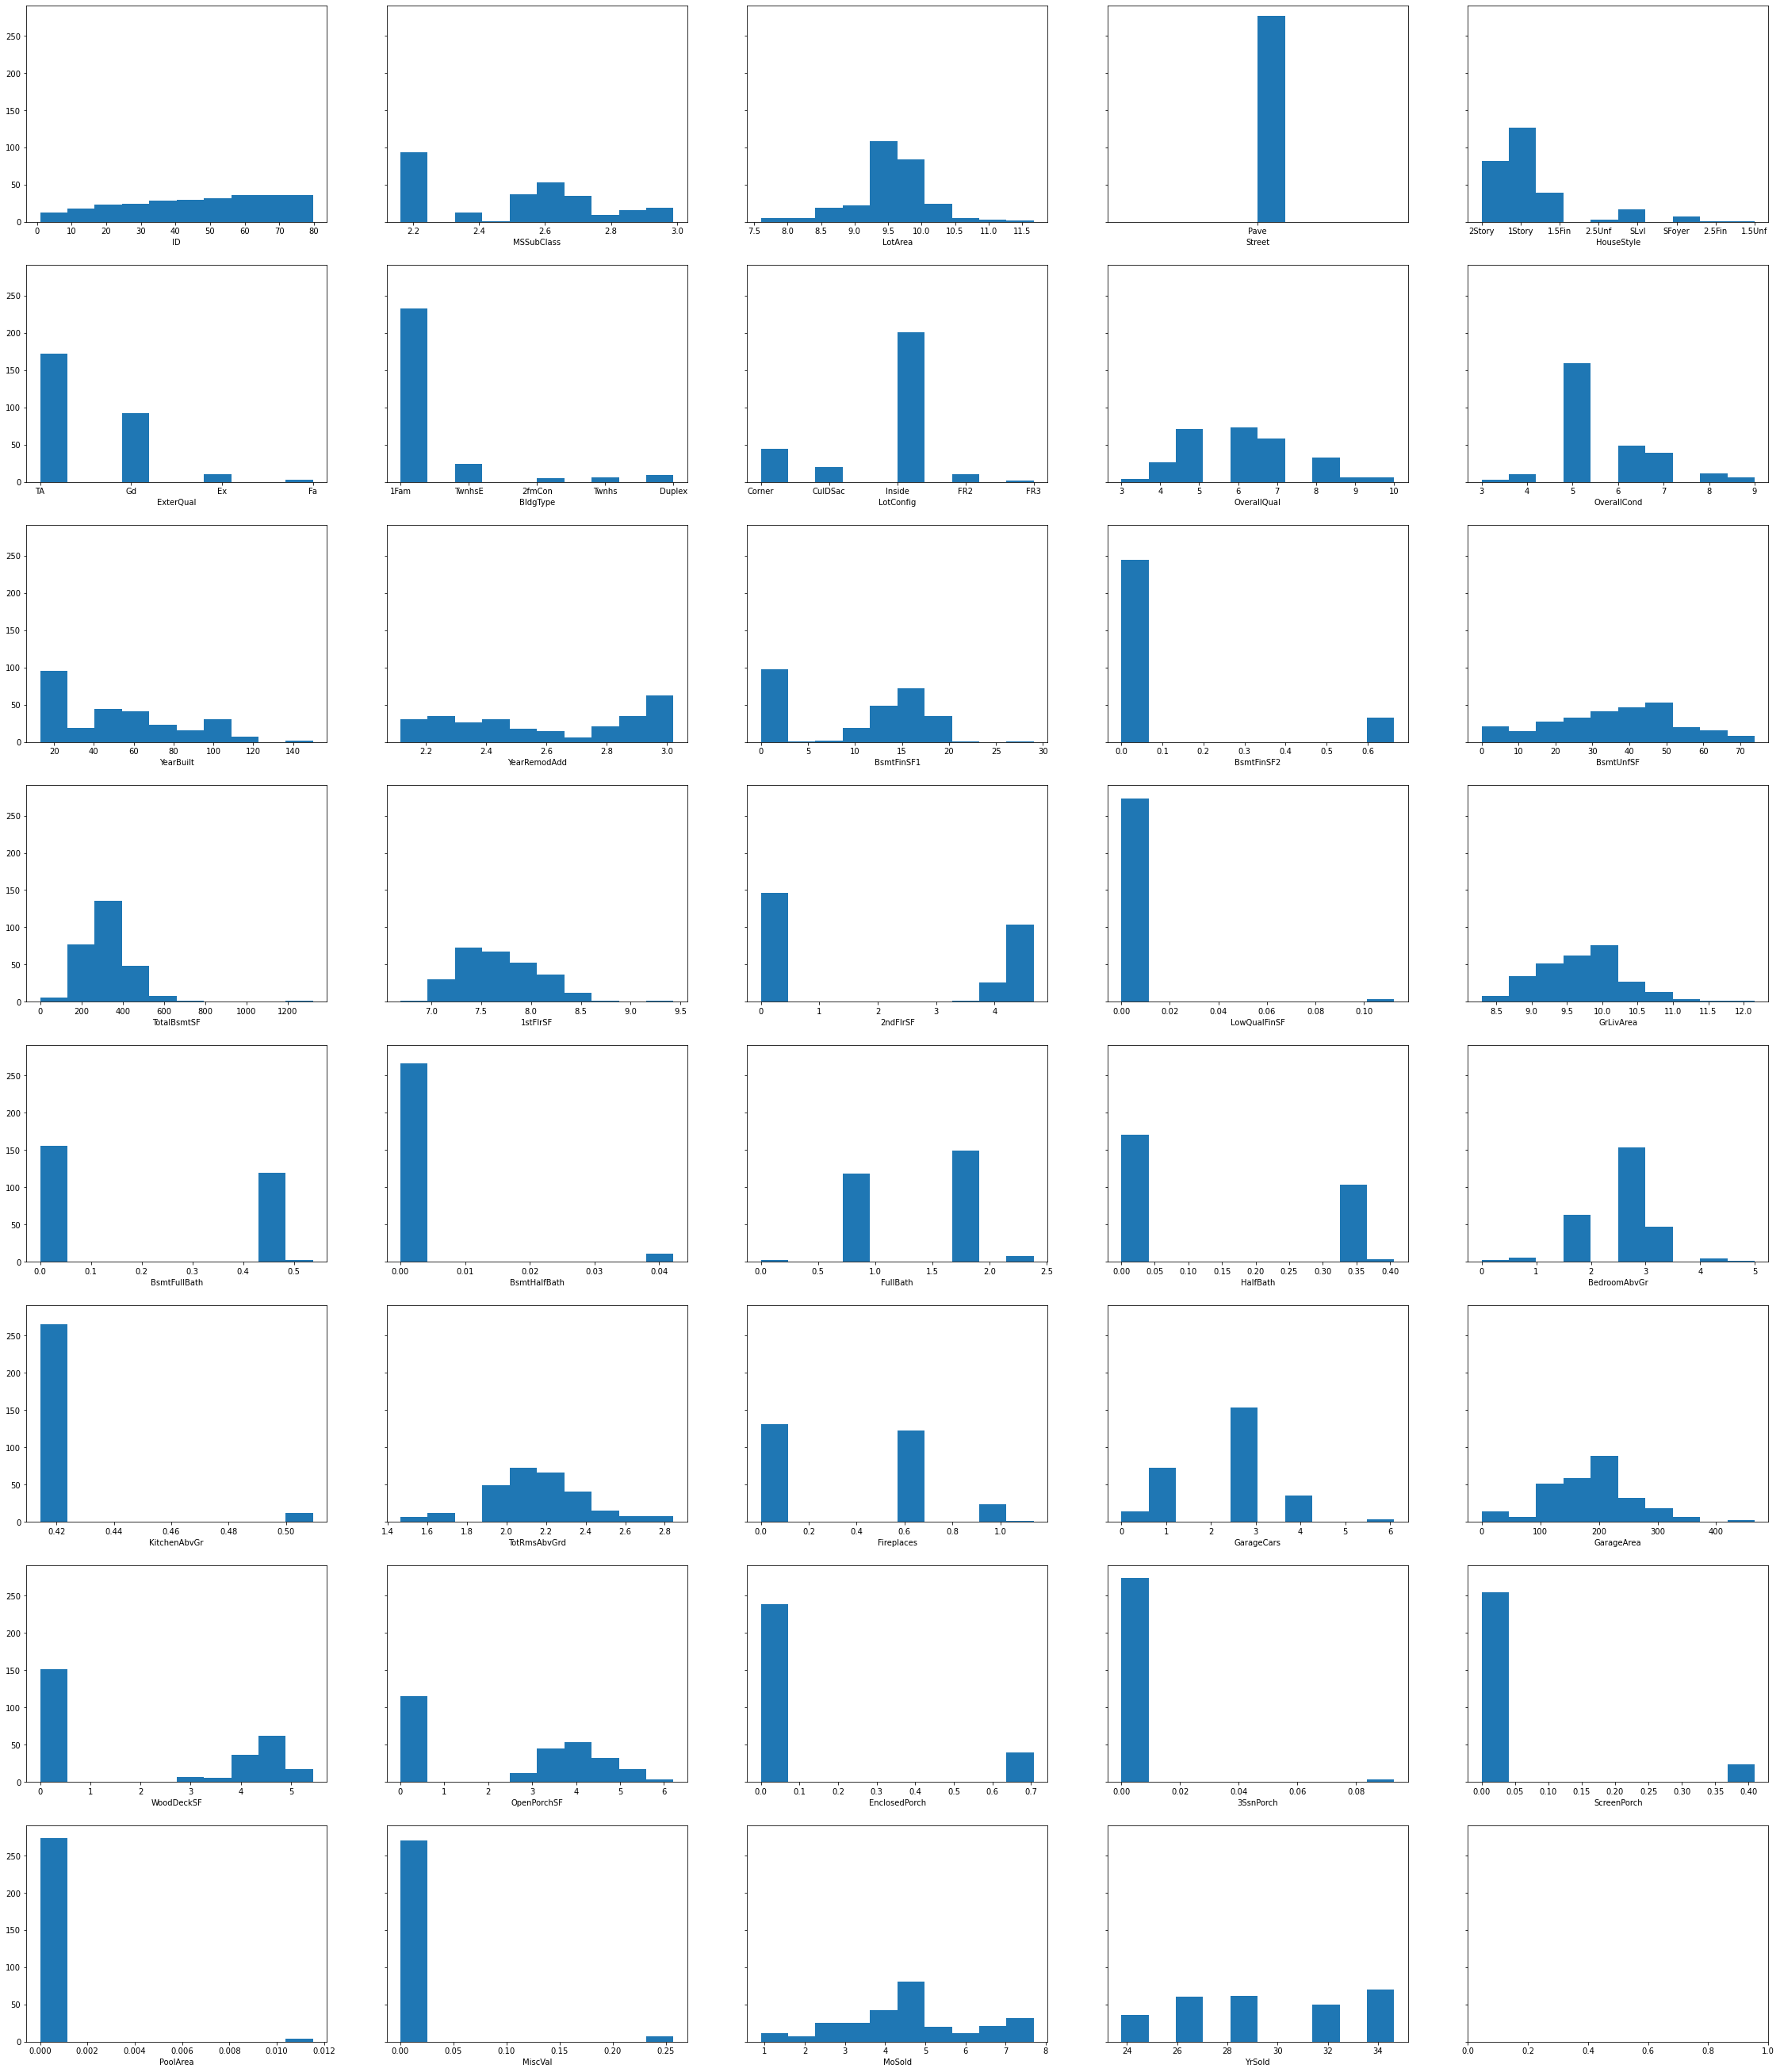

<Figure size 432x288 with 0 Axes>

In [330]:
plot_custom_subplot(test_imputed_unskewed.drop('SalePrice', axis = 1), test_imputed_unskewed['SalePrice'], plot_type='histogram')
plot_custom_subplot(test_dropped_unskewed.drop('SalePrice', axis = 1), test_dropped_unskewed['SalePrice'], plot_type='histogram')

(array([ 4.,  6., 23., 79., 75., 46., 30., 10.,  2.,  2.]),
 array([ 8.8419469 ,  9.00612334,  9.17029979,  9.33447623,  9.49865267,
         9.66282911,  9.82700556,  9.991182  , 10.15535844, 10.31953488,
        10.48371133]),
 <BarContainer object of 10 artists>)

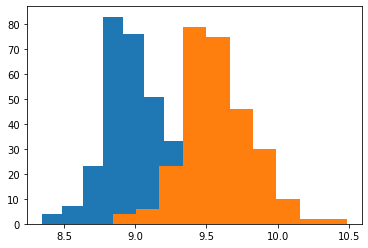

In [331]:
plt.hist(test_imputed_unskewed['SalePrice'])
plt.hist(test_dropped_unskewed['SalePrice'])

## 2.5 Encode categoricals in training data

In [332]:
# Find the columns with 'object' datatypes
def get_categoricals(dataframe) -> list:
    categoricals = []
    for col in dataframe.columns:
        if dataframe[col].dtypes == "object":
            categoricals.append(col)
    return categoricals

In [333]:
# Apply one hot encoding to categoricals.

def one_hot_encode(df, categoricals:list):
    """Dropping categoricals and concatenating one hot encoding."""

    df_copy = df.copy()
    for idx, category in enumerate(categoricals):
        variables_list = df_copy[category].unique()
        print(f'category: {category}: {variables_list}')
        if len(variables_list) == 2:
            set_arg = True # set drop_first true because categories are binary
        else:
            set_arg = False

        dummy1 = pd.get_dummies(df_copy[category], drop_first=set_arg)
        df_copy = pd.concat([df_copy, dummy1], axis=1).drop(category, axis=1)
    return df_copy


In [334]:
def encode_categoricals(data):

    categoricals = get_categoricals(data)
    data = one_hot_encode(data, categoricals)

    return data

In [335]:
print(test_dropped)

      ID  MSSubClass  LotArea Street HouseStyle ExterQual BldgType LotConfig  \
0      1          70    13728   Pave     2Story        TA     1Fam    Corner   
1      2          60    35760   Pave     2Story        Gd     1Fam   CulDSac   
3      4          20     9120   Pave     1Story        TA     1Fam    Inside   
4      5         160     4017   Pave     2Story        Gd   TwnhsE    Inside   
5      6          50    18030   Pave     1.5Fin        TA     1Fam    Inside   
..   ...         ...      ...    ...        ...       ...      ...       ...   
287  288          60     7917   Pave     2Story        TA     1Fam    Inside   
288  289          20    13175   Pave     1Story        TA     1Fam    Inside   
289  290          70     9042   Pave     2Story        Ex     1Fam    Inside   
290  291          20     9717   Pave     1Story        TA     1Fam    Inside   
291  292          20     9937   Pave     1Story        Gd     1Fam    Inside   

     OverallQual  OverallCond  ...  Woo

In [336]:
test_dropped_encoded = encode_categoricals(test_dropped)


category: Street: ['Pave']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '2.5Unf' 'SLvl' 'SFoyer' '2.5Fin' '1.5Unf']
category: ExterQual: ['TA' 'Gd' 'Ex' 'Fa']
category: BldgType: ['1Fam' 'TwnhsE' '2fmCon' 'Twnhs' 'Duplex']
category: LotConfig: ['Corner' 'CulDSac' 'Inside' 'FR2' 'FR3']


In [337]:
print(test_dropped)

      ID  MSSubClass  LotArea Street HouseStyle ExterQual BldgType LotConfig  \
0      1          70    13728   Pave     2Story        TA     1Fam    Corner   
1      2          60    35760   Pave     2Story        Gd     1Fam   CulDSac   
3      4          20     9120   Pave     1Story        TA     1Fam    Inside   
4      5         160     4017   Pave     2Story        Gd   TwnhsE    Inside   
5      6          50    18030   Pave     1.5Fin        TA     1Fam    Inside   
..   ...         ...      ...    ...        ...       ...      ...       ...   
287  288          60     7917   Pave     2Story        TA     1Fam    Inside   
288  289          20    13175   Pave     1Story        TA     1Fam    Inside   
289  290          70     9042   Pave     2Story        Ex     1Fam    Inside   
290  291          20     9717   Pave     1Story        TA     1Fam    Inside   
291  292          20     9937   Pave     1Story        Gd     1Fam    Inside   

     OverallQual  OverallCond  ...  Woo

In [338]:
train_imputed_encoded = encode_categoricals(train_imputed)
train_dropped_encoded = encode_categoricals(train_dropped)
train_imputed_unskewed_encoded  = encode_categoricals(train_imputed_unskewed)
train_dropped_unskewed_encoded = encode_categoricals(train_dropped_unskewed)

test_imputed_encoded  = encode_categoricals(test_imputed)
test_dropped_encoded = encode_categoricals(test_dropped)
test_imputed_unskewed_encoded  = encode_categoricals(test_imputed_unskewed)
test_dropped_unskewed_encoded = encode_categoricals(test_dropped_unskewed)


category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLv

## 2.6 Split train, test

In [339]:
def split(df):
    X = df.drop(['SalePrice'], axis=1)
    y = df['SalePrice']
    return X, y

# 3.Linear Regression

## 3.1 Setup regression loops

In [379]:
from sklearn import linear_model
from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math

def run_lin_regression(X_train, y_train, X_test, y_test, wrapped=False):
    # Create linear regression object (Ordinary Least Squares)
    models = dict(
        ols=linear_model.LinearRegression(), 
        ridge=linear_model.Ridge(alpha=0.1),
        huber= linear_model.HuberRegressor(max_iter=100000),
        ransac =linear_model.RANSACRegressor(random_state=0),
        theil_sen= linear_model.TheilSenRegressor()
    )

    result = []
    for name, model in models.items():
        print(f'\nRunning {name} regression.')
        if wrapped == True:
            pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', model)])
            wrapped_model = compose.TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
            wrapped_model.fit(X_train, y_train)
            y_predicted = wrapped_model.predict(X_test)
        else:
            # Train the model using the training sets
            model.fit(X_train, y_train)
            # Make predictions using the testing set
            y_predicted = model.predict(X_test)

        # Evaluate
        # The coefficients
        # print("Coefficients: \n", reg.coef_)
        # The mean squared error
        mse = mean_squared_error(y_test, y_predicted)
        rmse = math.sqrt(mse)
        print("Root Mean Squared Error: %.3f" % rmse)
        # The coefficient of determination: 1 is perfect prediction
        r2 = r2_score(y_test, y_predicted)
        print("Coefficient of determination: %.3f" % r2)
        result.append((y_predicted, rmse, r2, name))
    return result

## 3.2 Setup result inspection

In [341]:
def plot_predictions(result, y_test, data_in='no_mods'):

    num_plots = len(result)
    num_rows = 1
    fig, ax_array =  plt.subplots(num_rows, num_plots, figsize=(100/2.54, 10/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        # Unpack
        y_predict = result[k][0]
        r2 = result[k][2]
        model_name = result[k][3]

        ax_row.set_xlabel(model_name + ' R2:' + str(round(r2, 3)))
        ax_row.scatter(y_predict, y_test)
        k += 1
        if k == num_plots:
            break
    
    plt.show()    
    plt.savefig('predictions_vs_test' + data_in + '.png', format='png')
    

## 3.3 Run Single Model

### 3.3.1 On dropped data


Running ols regression.
Mean squared error: 2362678002.987
Coefficient of determination: 0.656

Running ridge regression.
Mean squared error: 2362677456.631
Coefficient of determination: 0.656

Running huber regression.
Mean squared error: 3457274795.491
Coefficient of determination: 0.496

Running ransac regression.
Mean squared error: 2586579749.537
Coefficient of determination: 0.623

Running theil_sen regression.
Mean squared error: 2665947444.934
Coefficient of determination: 0.611


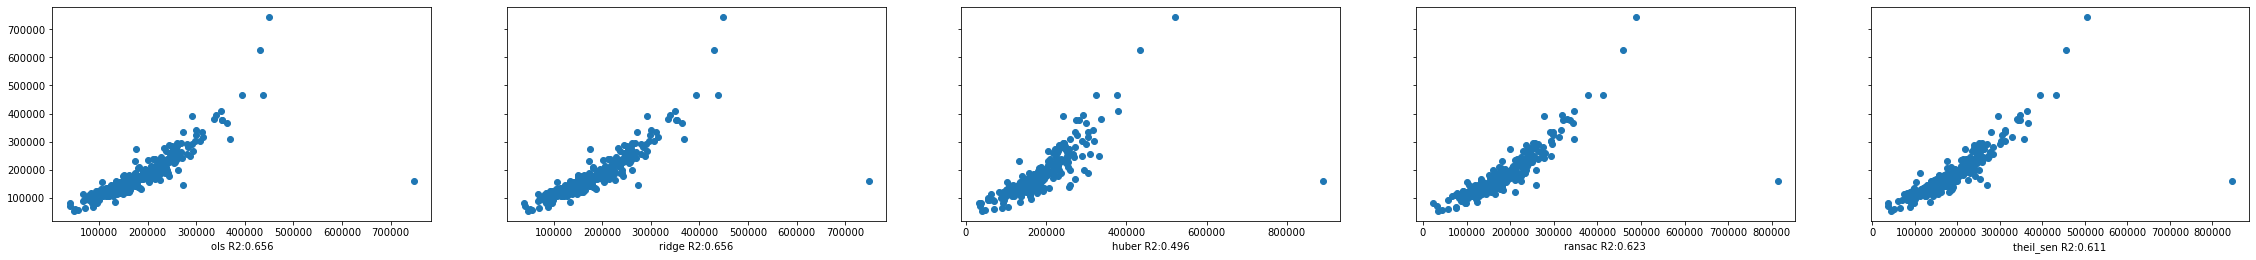

<Figure size 432x288 with 0 Axes>

In [342]:
X_train_D, y_train_D = split(train_dropped_encoded)
X_test_D, y_test_D = split(test_dropped_encoded)

result = run_lin_regression(X_train_D, y_train_D, X_test_D, y_test_D)
plot_predictions(result, y_test_D, data_in='only dropped')


### 3.3.2 On Imputed data


Running ols regression.
Mean squared error: 2277798917.477
Coefficient of determination: 0.660

Running ridge regression.
Mean squared error: 2277868861.001
Coefficient of determination: 0.660

Running huber regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 2325624103.164
Coefficient of determination: 0.653

Running ransac regression.
Mean squared error: 5199523377.501
Coefficient of determination: 0.225

Running theil_sen regression.
Mean squared error: 2623636164.901
Coefficient of determination: 0.609


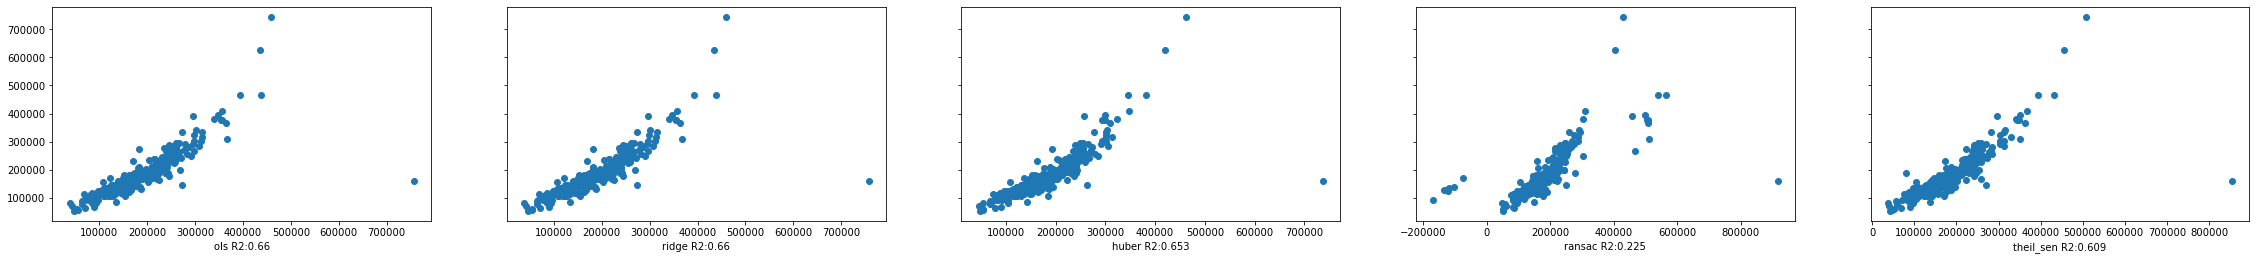

<Figure size 432x288 with 0 Axes>

In [343]:
X_train_I, y_train_I = split(train_imputed_encoded)
X_test_I, y_test_I = split(test_imputed_encoded)

result = run_lin_regression(X_train_I, y_train_I, X_test_I, y_test_I) # why does this shit out on huber?
plot_predictions(result, y_test_I, data_in='only imputed')

### 3.3.3 On dropped and unskewed data


Running ols regression.
Mean squared error: 0.011
Coefficient of determination: 0.813

Running ridge regression.
Mean squared error: 0.011
Coefficient of determination: 0.809

Running huber regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 0.013
Coefficient of determination: 0.783

Running ransac regression.
Mean squared error: 0.013
Coefficient of determination: 0.779

Running theil_sen regression.
Mean squared error: 0.021
Coefficient of determination: 0.654


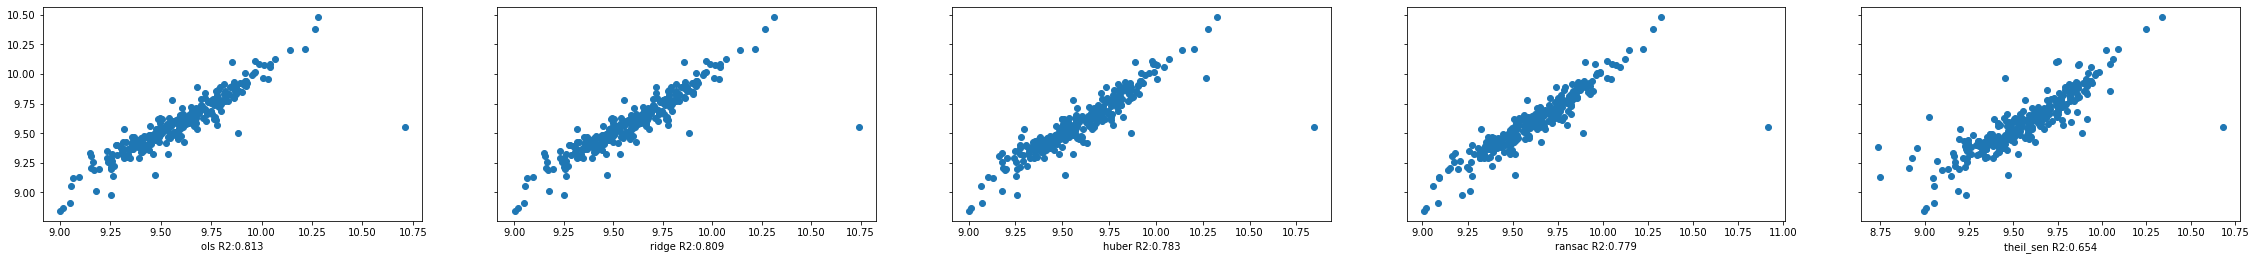

<Figure size 432x288 with 0 Axes>

In [344]:
X_train_DU, y_train_DU = split(train_dropped_unskewed_encoded)
X_test_DU, y_test_DU = split(test_dropped_unskewed_encoded)

result = run_lin_regression(X_train_DU, y_train_DU, X_test_DU, y_test_DU) # why does this shit out on huber?
plot_predictions(result, y_test_DU, data_in='dropped and unskewed')

### 3.3.3 On Imputed and unskewed data


Running ols regression.
Mean squared error: 0.008
Coefficient of determination: 0.818

Running ridge regression.
Mean squared error: 0.008
Coefficient of determination: 0.815

Running huber regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 0.010
Coefficient of determination: 0.777

Running ransac regression.
Mean squared error: 0.032
Coefficient of determination: 0.276

Running theil_sen regression.
Mean squared error: 0.029
Coefficient of determination: 0.347


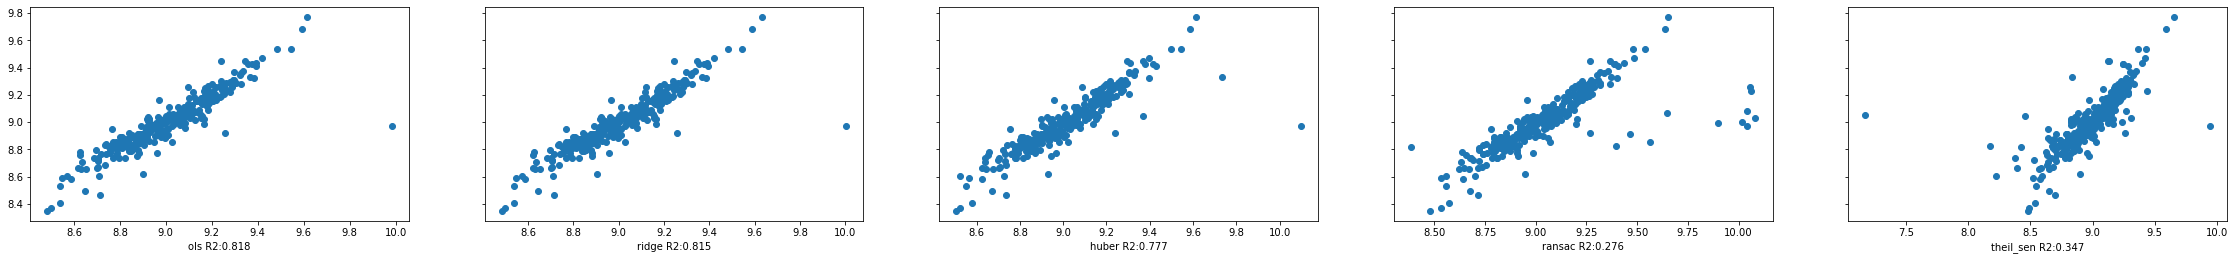

<Figure size 432x288 with 0 Axes>

In [345]:
X_train_IU, y_train_IU = split(train_imputed_unskewed_encoded)
X_test_IU, y_test_IU = split(test_imputed_unskewed_encoded)

result = run_lin_regression(X_train_IU, y_train_IU, X_test_IU, y_test_IU) # why does this shit out on huber?
plot_predictions(result, y_test_IU, data_in='imputed and unskewed')


# 4.  Ensemble Models

# 4.1 Setup Ensemble Models

In [377]:
# from sklearn.ensemble import VotingRegressor 

# def run_ensemble_lin_regression(X_train, y_train, X_test, y_test):

#     ols=linear_model.LinearRegression(), 
#     # ridge=linear_model.ridge_regression(alpha=0.1),
#     huber= linear_model.HuberRegressor(max_iter=100000),
#     ransac =linear_model.RANSACRegressor(random_state=0),
#     theil_sen= linear_model.TheilSenRegressor()

#     # eclf1 = VotingRegressor(estimators=[('lr', ols), ('ridge', ridge), ('huber', huber), ('ransac', ransac), ('theil_sen', theil_sen)])
    
#     eclf1 = VotingRegressor(estimators=[('lr', ols), ('huber', huber), ('ransac', ransac), ('theil_sen', theil_sen)])
#     eclf1 = eclf1.fit(X_train, y_train)
#     y_predicted= eclf1.predict(X_test)

#     mse = mean_squared_error(y_test, y_predicted)
#     print("Mean squared error: %.3f" % mse)
#     r2 = r2_score(y_test, y_predicted)
#     print("Coefficient of determination: %.3f" % r2)
#     result.append((y_predicted, mse, r2))

#     return eclf1, result


In [378]:
# model, result = run_ensemble_lin_regression(X_train_D, y_train_D, X_test_D, y_test_D)
# # plot_predictions(result, y_test_D, data_in='only dropped')


ValueError: The estimator tuple should be a regressor.

# 4. Questions

## Task 1 
Apply two techniques to handle missing data
Justify why these two techniques were chosen
compare the regression model's performance on the two data sets

## Task 2
 Write Python code to build a regression model from the training set that you applied the better
solution in (1). Write the code to evaluate its performance on the test set that you applied the better
solution in (1) with Root-Mean-Squared-Error (RMSE). RMSE shares similar motivation of the least
square loss we taught in the lecture. Section 5 gives reference for the definition. Please try at least
two regression models and compare their performances.  

## Task 3
There are 38 features provided for each house. Are all of the features used in your regression
models? What’s the impact if removing some features? Please write your own code to compare
different feature selections and justify your selection. At least two feature selections are investigated
(full feature set, a subset of the features). The dataset is the modified ones that you applied the
better solution in (1). (6 Marks)

In [346]:
def create_data_subset(X_train, X_test, columns_to_drop):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    for column in columns_to_drop:
        X_train_copy = X_train_copy.drop([column], axis=1)
        X_test_copy = X_test_copy.drop([column], axis=1)
    return X_train_copy, X_test_copy

In [347]:
# drop ID because it contains no information about the house
# drop MSsubclass because the that information is repeated in the categoricals anyway with more fidelity
# drop MoSold - assume no seasonal price trends
# drop MiscVal - seems immaterial
# drop Fireplaces - seems incidental to the house sale

# query is sale price adjusted for inflation?

columns_to_drop = ['ID', 'MSSubClass', 'MoSold', 'MiscVal', 'Fireplaces'] # Removing these feature = no change in coef. determin. 0.817 of ransac regression


Running ols regression.
Mean squared error: 0.008
Coefficient of determination: 0.817

Running ridge regression.
Mean squared error: 0.008
Coefficient of determination: 0.815

Running huber regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 0.011
Coefficient of determination: 0.750

Running ransac regression.
Mean squared error: 0.043
Coefficient of determination: 0.035

Running theil_sen regression.
Mean squared error: 0.030
Coefficient of determination: 0.326


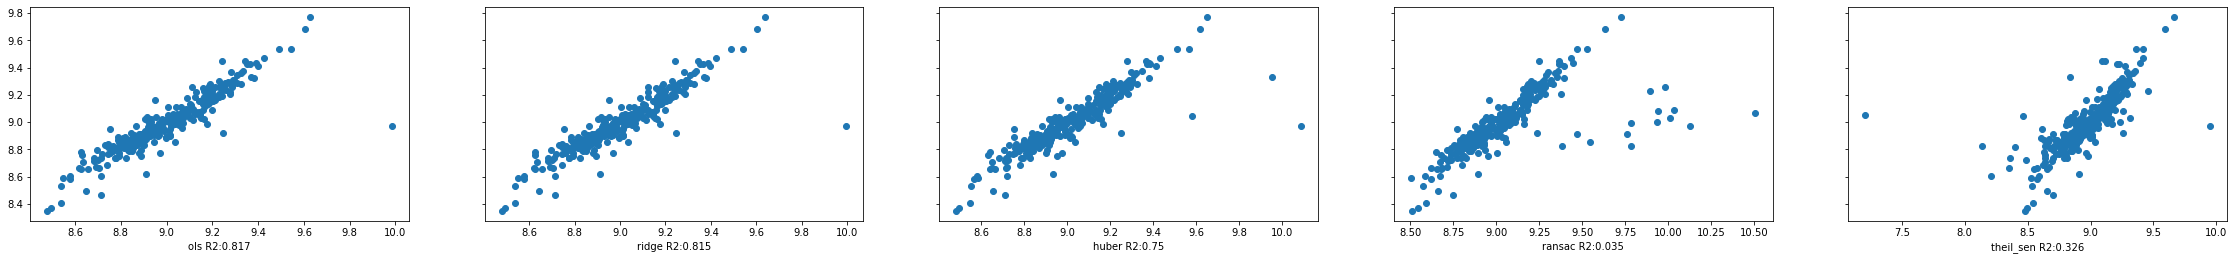

<Figure size 432x288 with 0 Axes>

In [348]:
X_train_IUD, X_test_IUD= create_data_subset(X_train_IU, X_test_IU, columns_to_drop)

result = run_lin_regression(X_train_IUD, y_train_IU, X_test_IUD, y_test_IU) # why does this shit out on huber?
plot_predictions(result, y_test_IU, data_in='imputed and unskewed and extra drops')


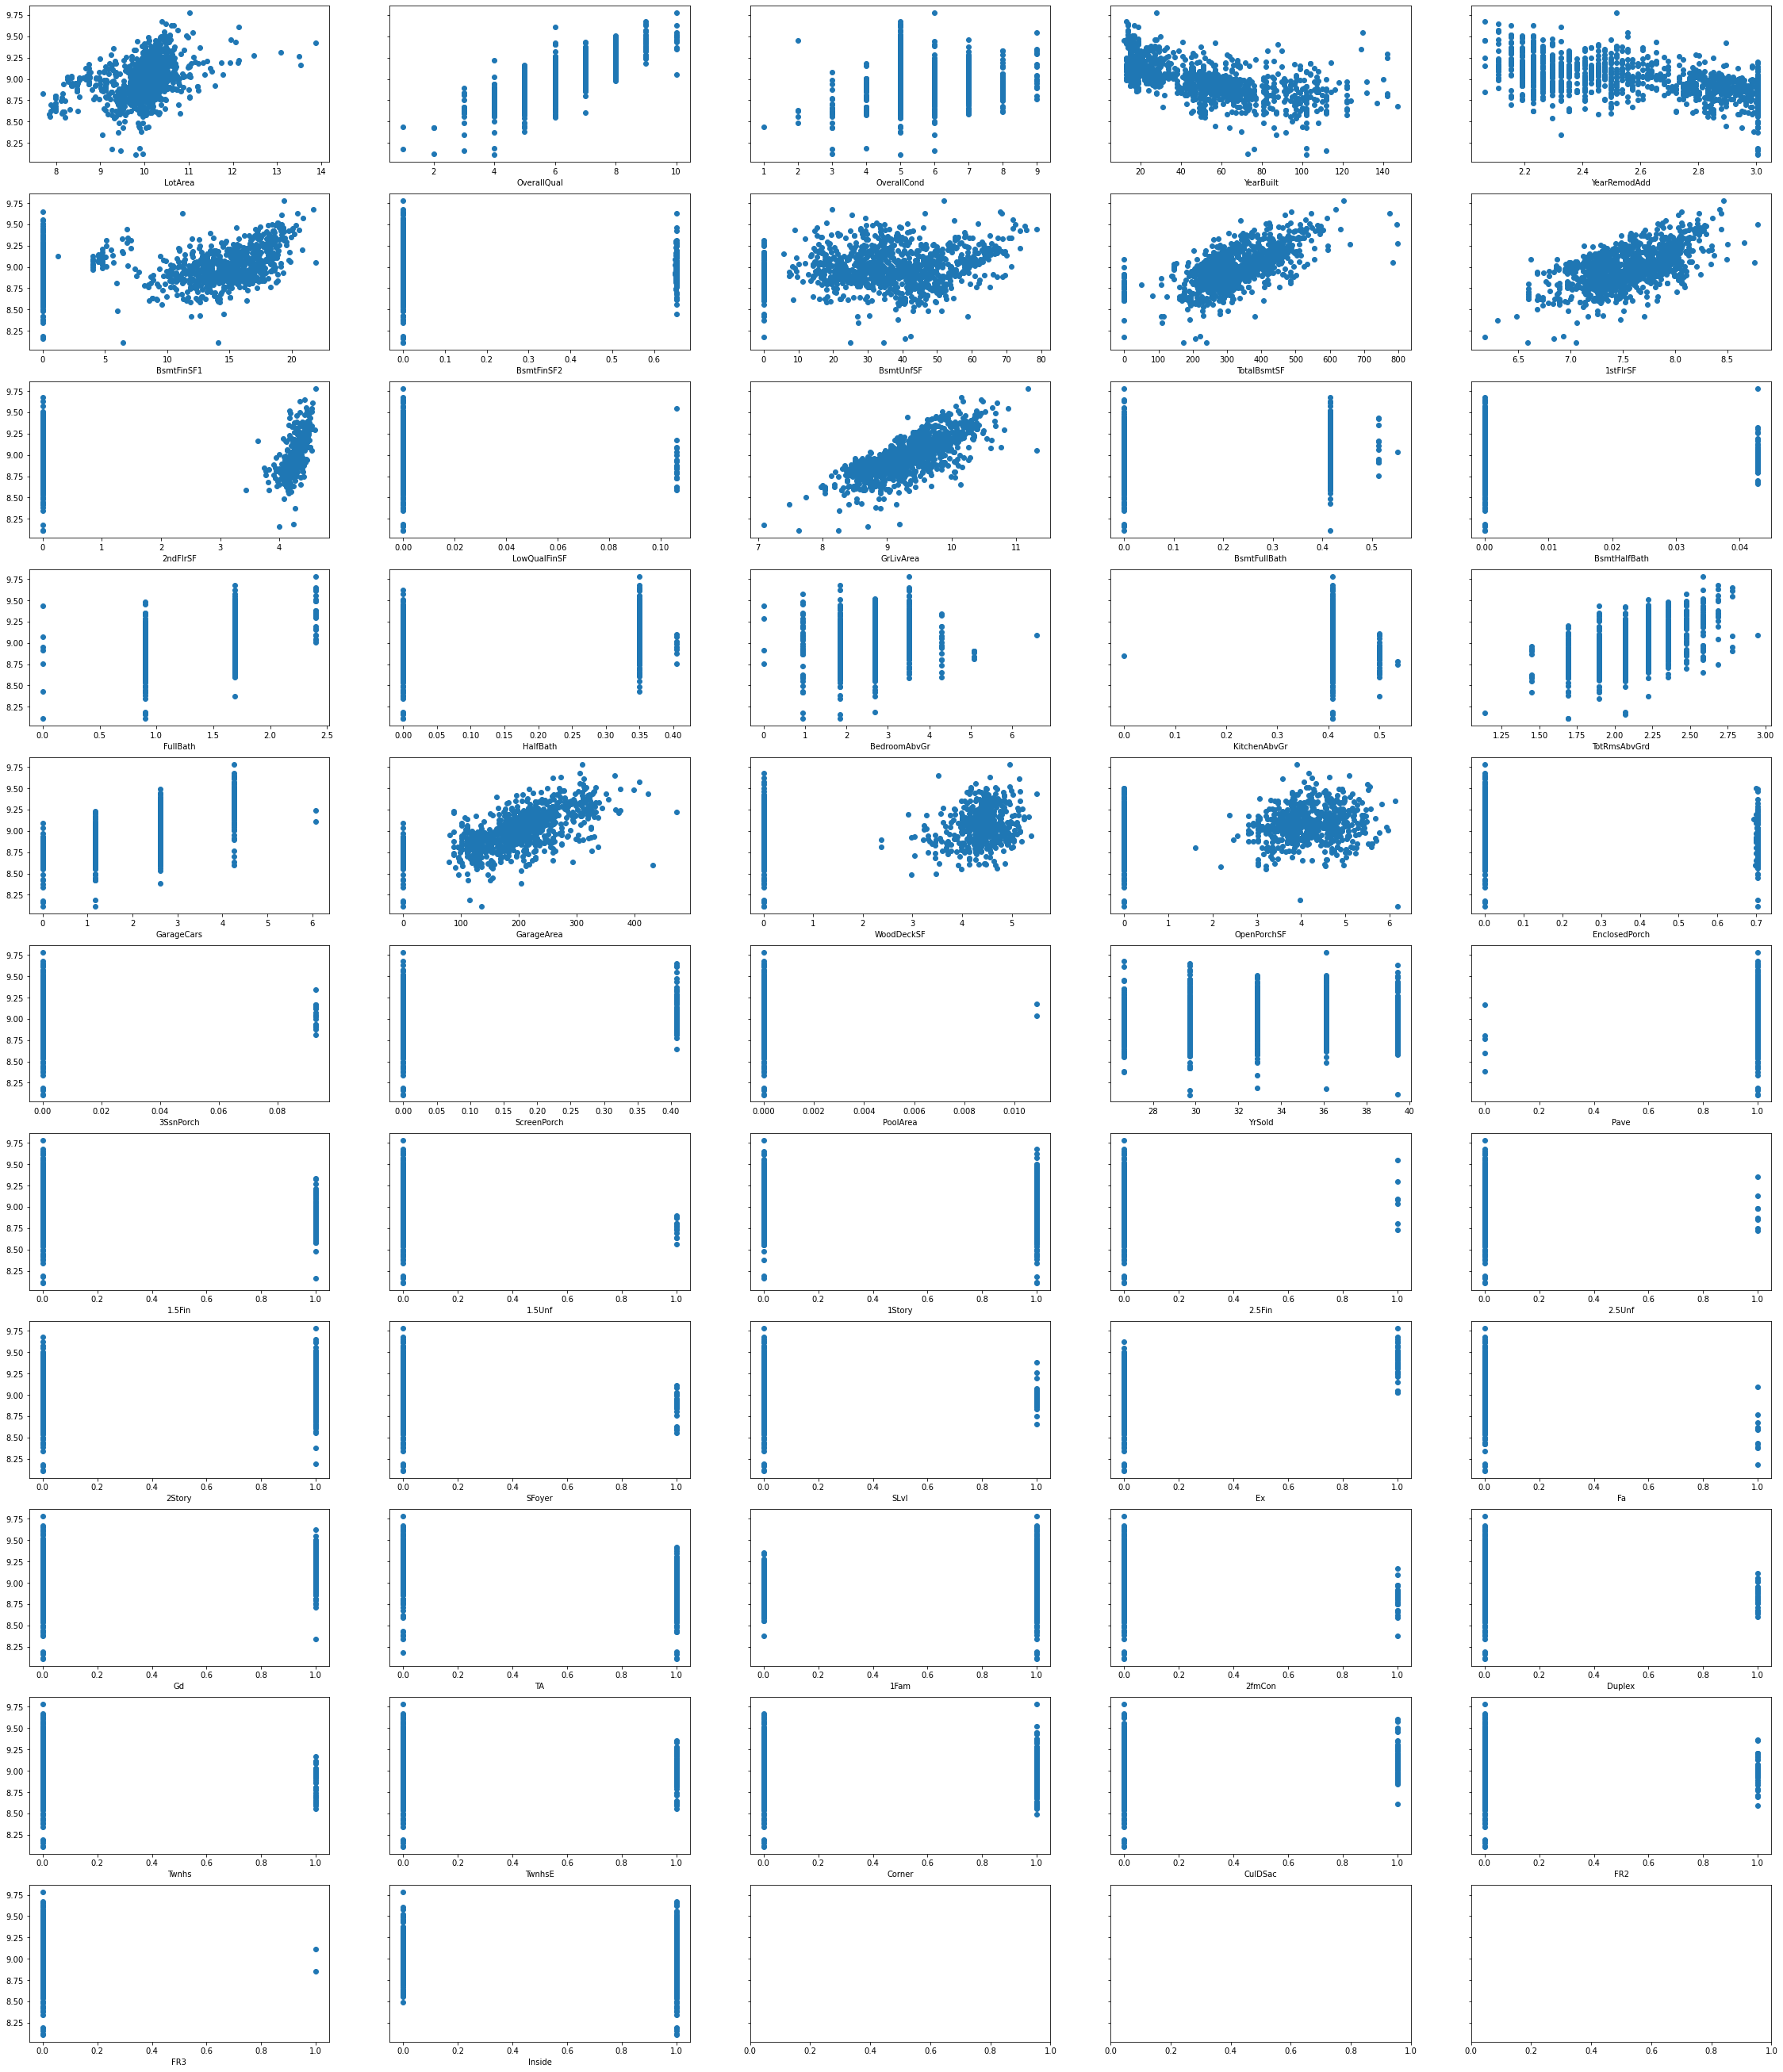

<Figure size 432x288 with 0 Axes>

In [349]:
plot_custom_subplot(X_train_IUD, y_train_IU)



<AxesSubplot:>

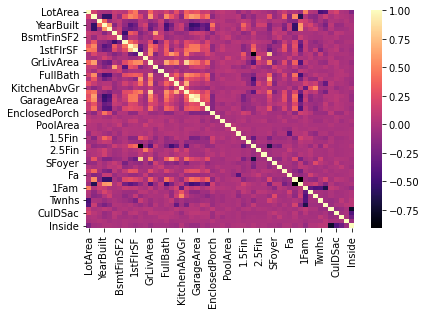

In [350]:
sb.heatmap(X_train_IUD.corr(), cmap = 'magma')


In [351]:
columns_to_drop = ['PoolArea'] # Removing these feature = no change in coef. determin. 0.817 of ransac regression


Running ols regression.
Mean squared error: 0.008
Coefficient of determination: 0.816

Running ridge regression.
Mean squared error: 0.008
Coefficient of determination: 0.815

Running huber regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 0.011
Coefficient of determination: 0.746

Running ransac regression.
Mean squared error: 0.010
Coefficient of determination: 0.780

Running theil_sen regression.
Mean squared error: 0.030
Coefficient of determination: 0.319


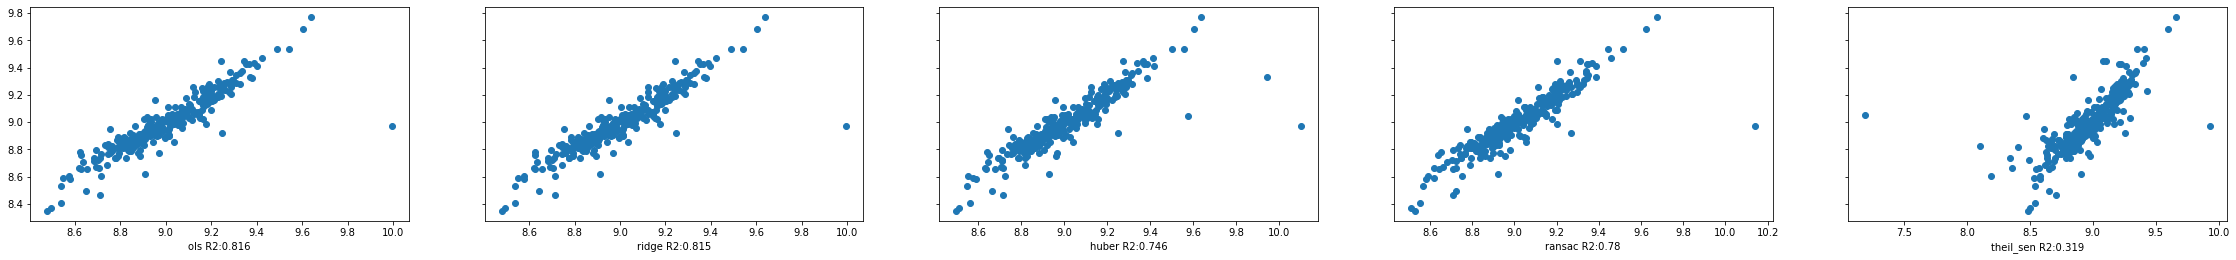

<Figure size 432x288 with 0 Axes>

In [352]:
X_train_IUDD, X_test_IUDD= create_data_subset(X_train_IUD, X_test_IUD, columns_to_drop)

result = run_lin_regression(X_train_IUDD, y_train_IU, X_test_IUDD, y_test_IU) # why does this shit out on huber?
plot_predictions(result, y_test_IU, data_in='imputed and unskewed and extra drops')
